### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/risk_correlation/alabama/2023_07_24_07_52_18/count_data

deaths.csv                       risk_exposure_time.hdf
deaths.hdf                       sbp_medication_person_time.csv
healthcare_visits.csv            sbp_medication_person_time.hdf
healthcare_visits.hdf            state_person_time.csv
intervention_person_time.csv     state_person_time.hdf
intervention_person_time.hdf     transition_count.csv
ldlc_medication_person_time.csv  transition_count.hdf
ldlc_medication_person_time.hdf  ylds.csv
polypill_person_time.csv         ylds.hdf
polypill_person_time.hdf         ylls.csv
risk_exposure_time.csv           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/risk_correlation/alabama/2023_07_24_07_52_18/count_data'

## Checking Stability of Risks over Time

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.loc[person_time.scenario == 'baseline']
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw']).ptvalue.sum().reset_index()
per_time_group.head()

age     sex  year  input_draw      ptvalue
0  25_to_29  Female  2023          29  1832.246407
1  25_to_29  Female  2023         232  1769.768652
2  25_to_29  Female  2023         357  1781.267625
3  25_to_29  Female  2023         394  1746.157426
4  25_to_29  Female  2023         602  1770.688569

In [5]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

Unnamed: 0     sex  year                            risk  \
0           0  Female  2023  high_body_mass_index_in_adults   
1           1  Female  2023  high_body_mass_index_in_adults   
2           2  Female  2023  high_body_mass_index_in_adults   
3           3  Female  2023  high_body_mass_index_in_adults   
4           4  Female  2023  high_body_mass_index_in_adults   

              measure  input_draw  scenario       age         value  
0  risk_exposure_time          29  baseline  25_to_29  57217.905006  
1  risk_exposure_time          29  baseline  30_to_34  54405.647245  
2  risk_exposure_time          29  baseline  35_to_39  53368.134637  
3  risk_exposure_time          29  baseline  40_to_44  53336.357453  
4  risk_exposure_time          29  baseline  45_to_49  54298.347794

### SBP

In [7]:
ldl_exp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ_sbp = (ldl_exp_rate
                .groupby(['age', 'sex', 'year'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ_ptvalue = (ldl_exp_rate
                .groupby(['age', 'sex', 'year'])
                .ptvalue.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

age     sex  year        mean        2.5%       97.5%
0  25_to_29  Female  2023  109.981705  107.749910  112.793375
1  25_to_29  Female  2024  109.922225  107.550561  112.757615
2  25_to_29  Female  2025  110.021278  107.514800  112.700798
3  25_to_29  Female  2026  109.936061  107.580475  112.454515
4  25_to_29  Female  2027  109.928920  107.620379  112.743116

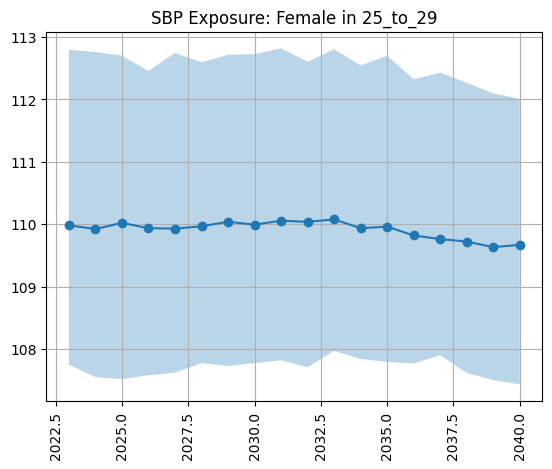

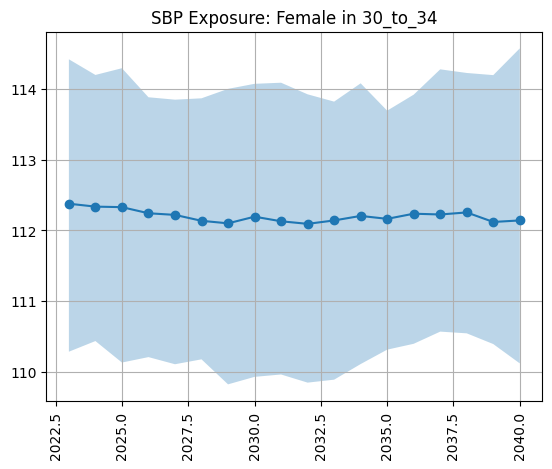

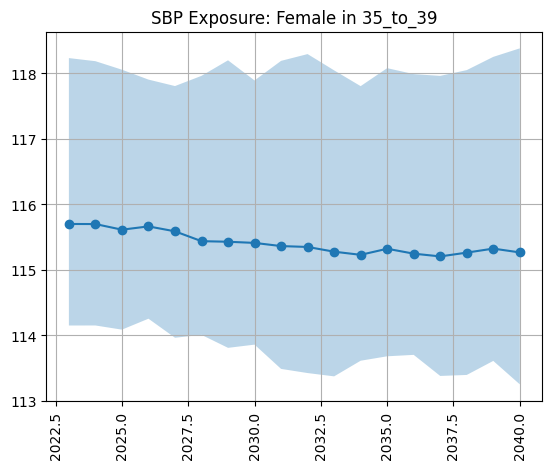

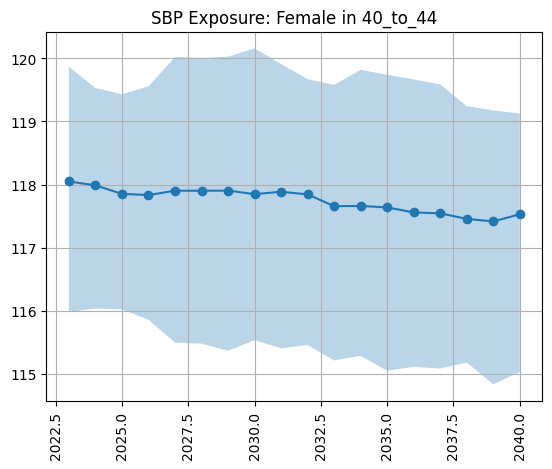

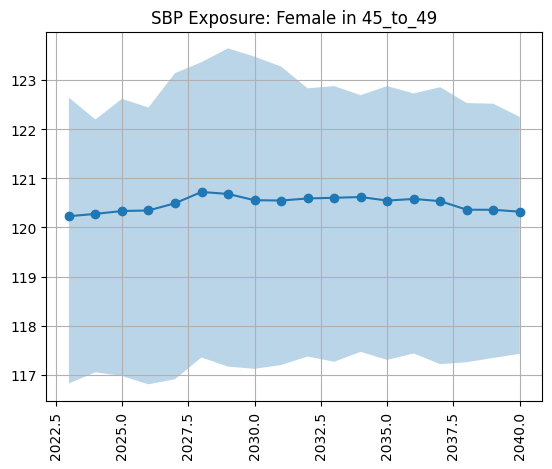

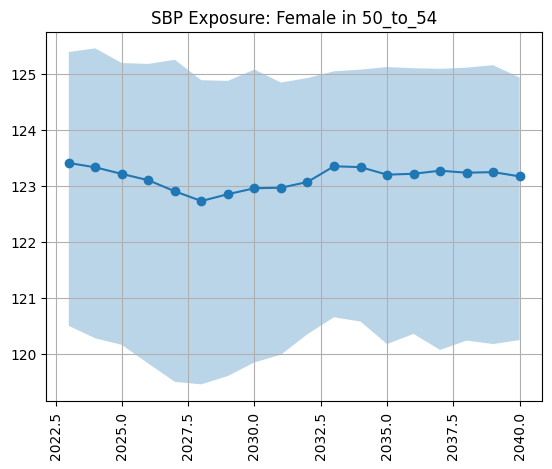

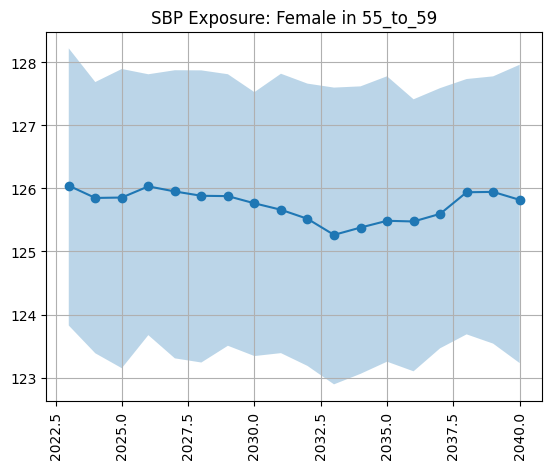

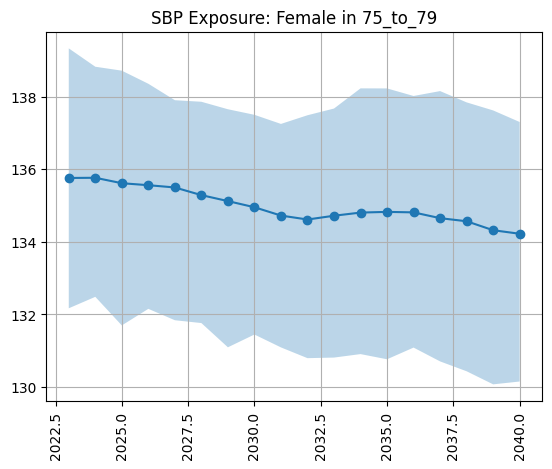

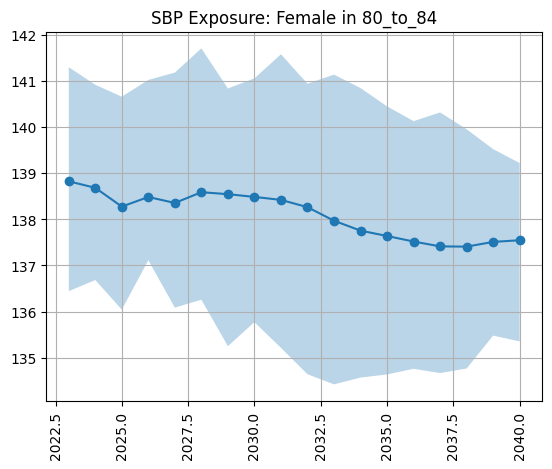

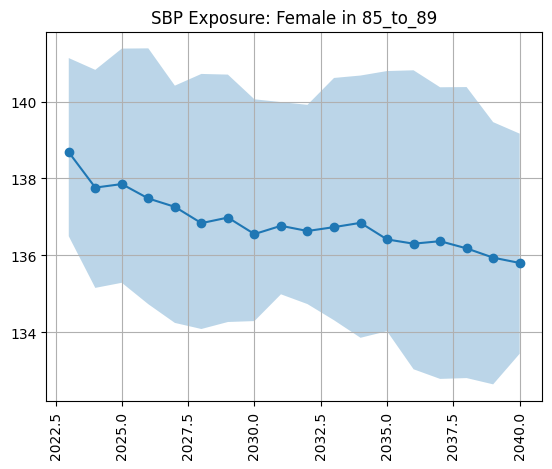

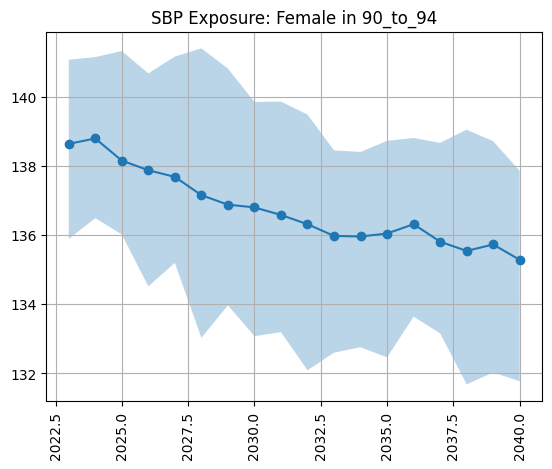

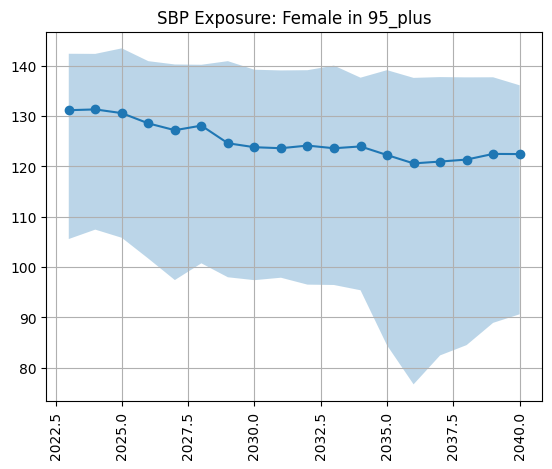

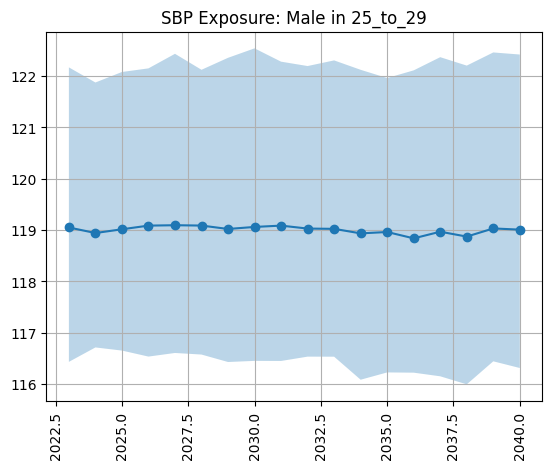

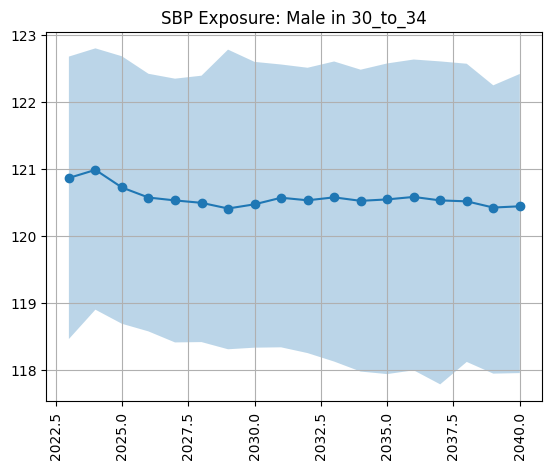

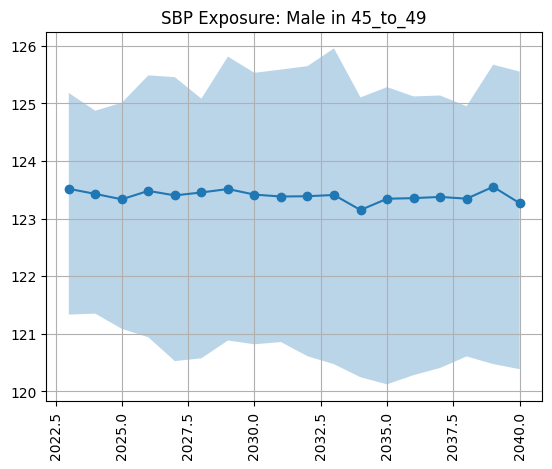

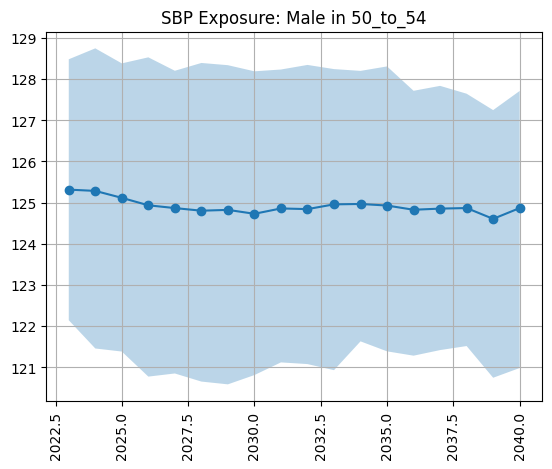

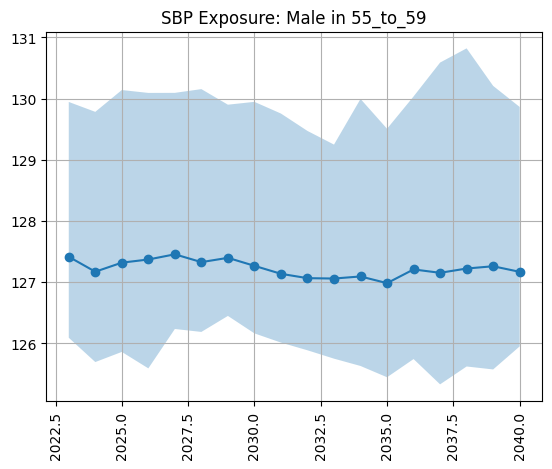

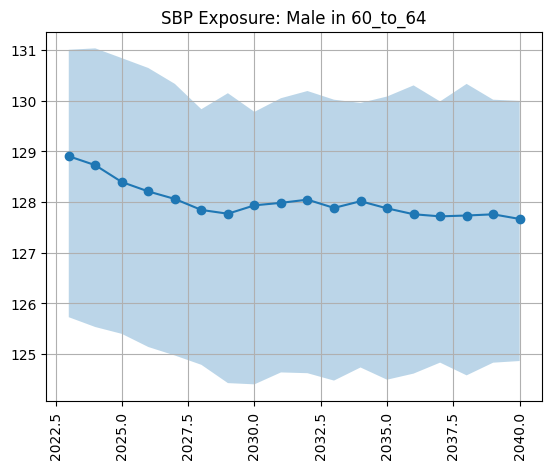

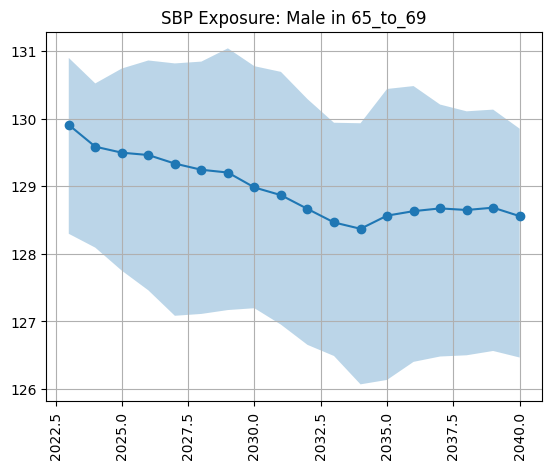

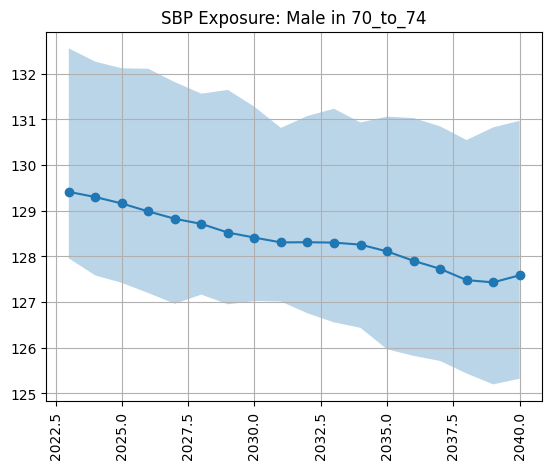

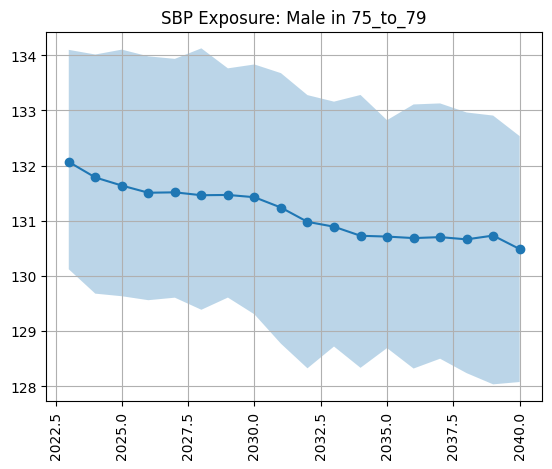

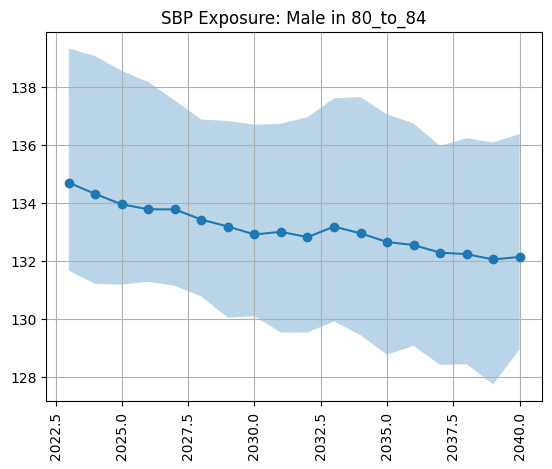

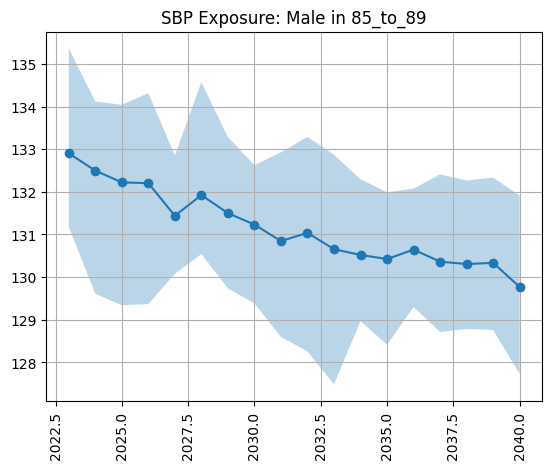

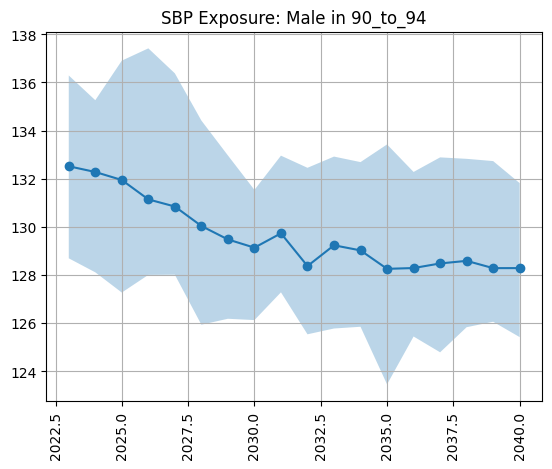

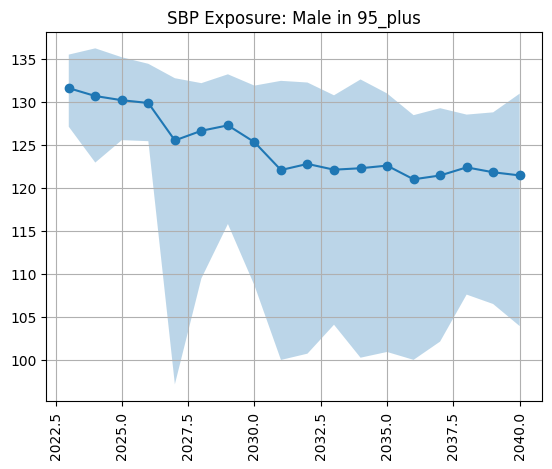

In [8]:
#%%capture
for sex in ldl_exp_rate_summ.sex.unique():
    for age in ldl_exp_rate_summ.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

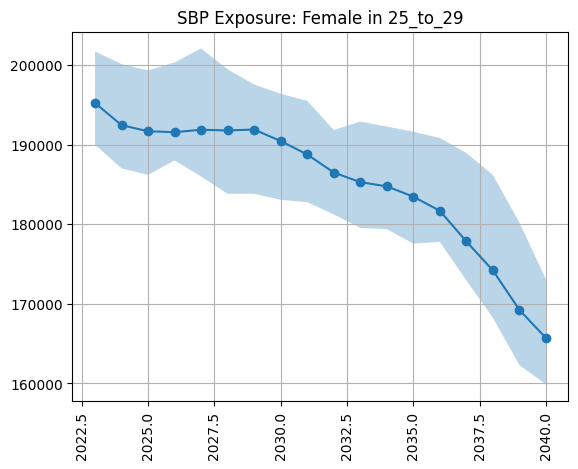

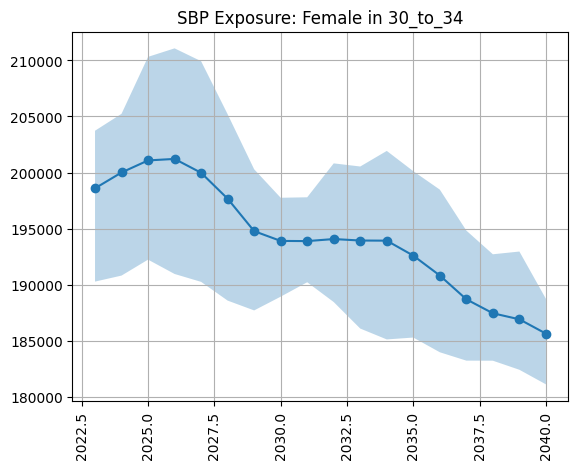

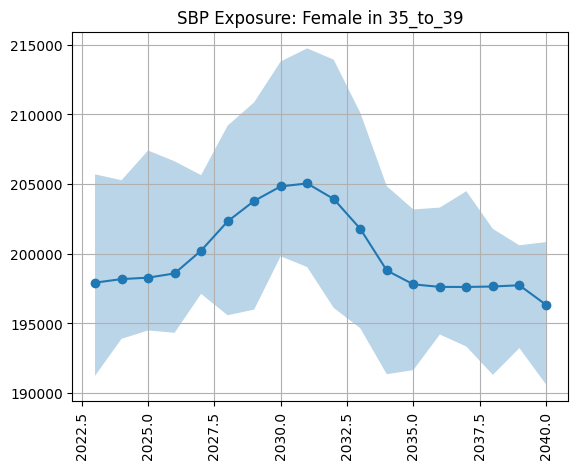

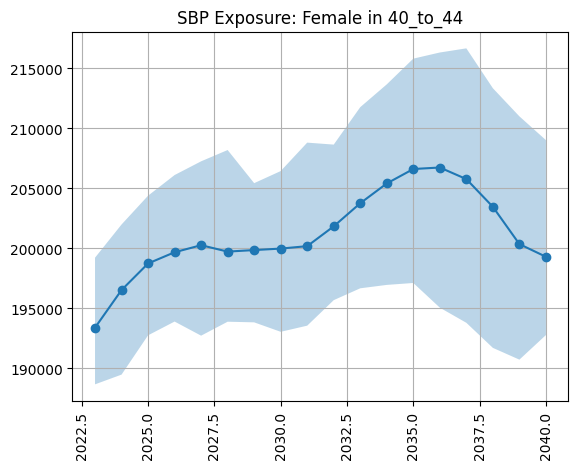

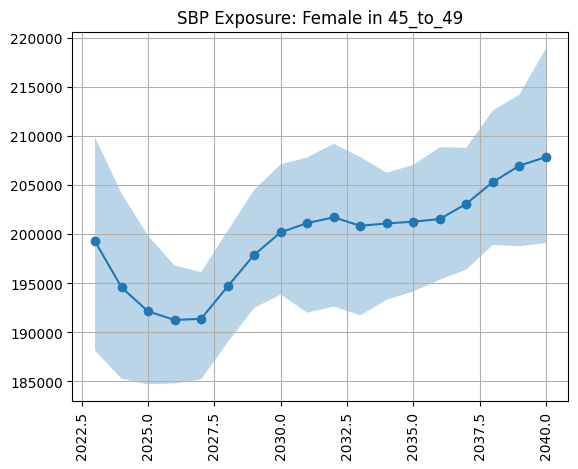

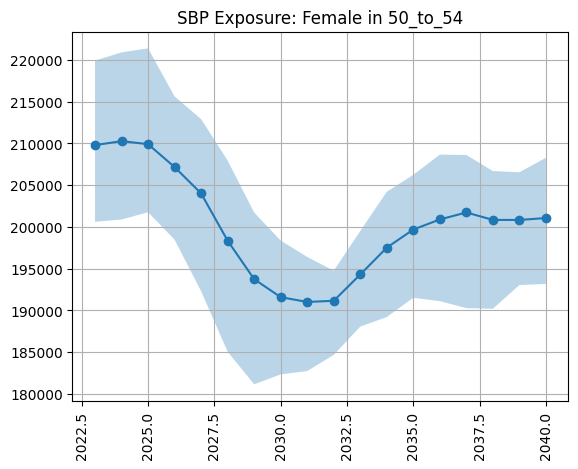

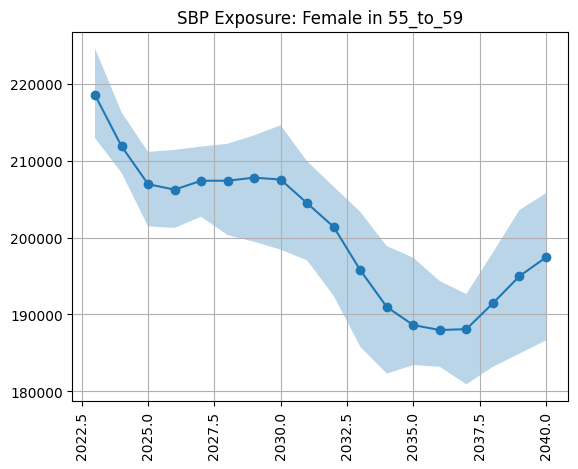

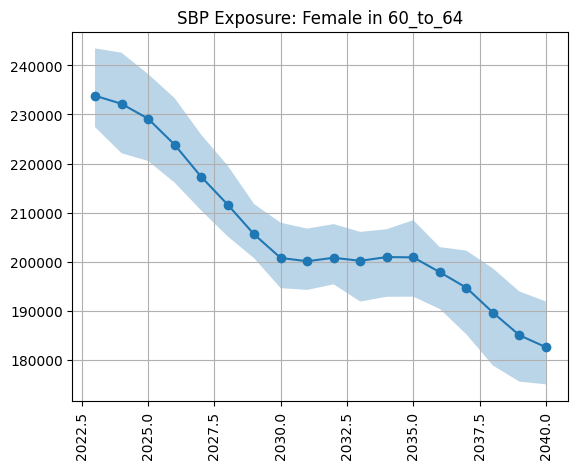

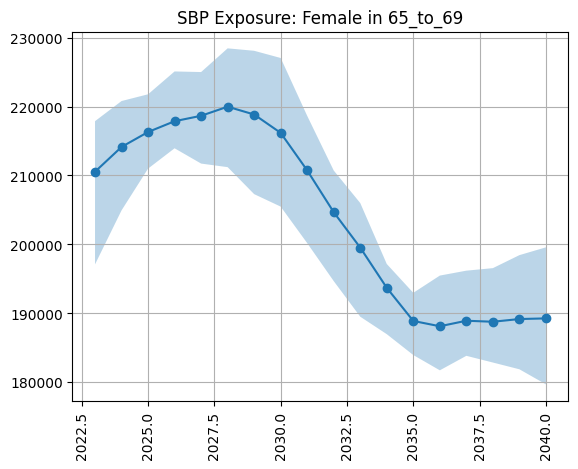

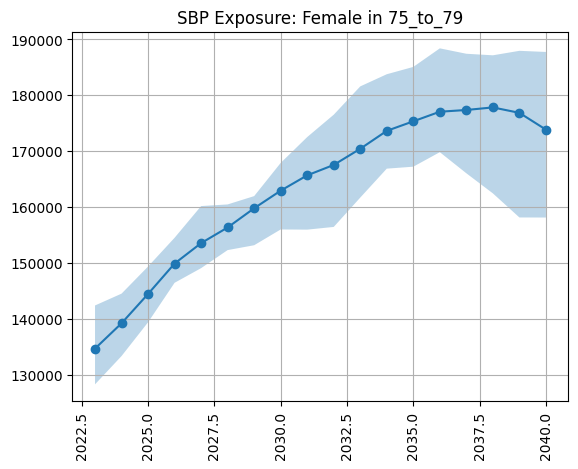

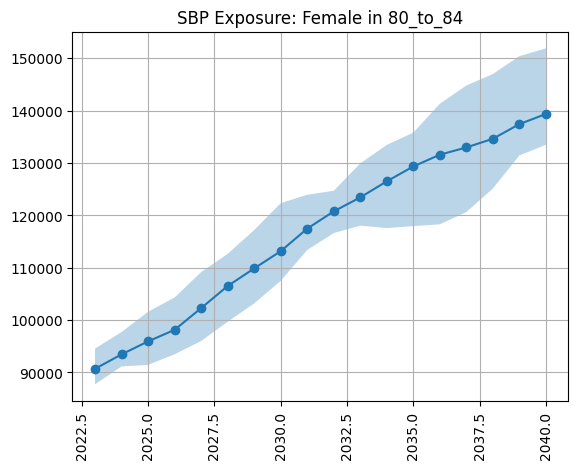

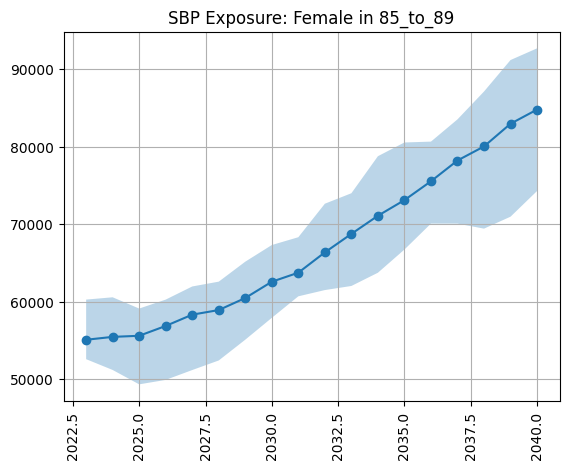

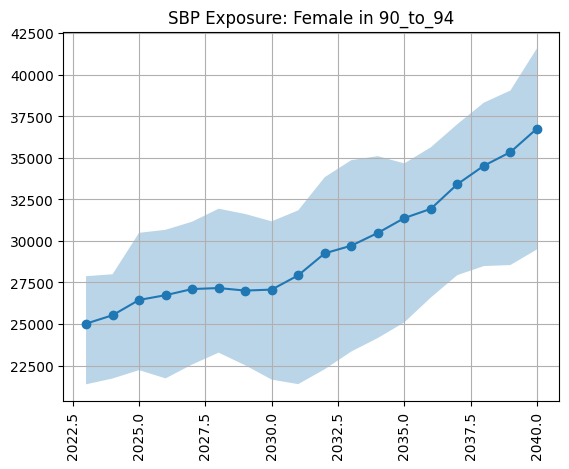

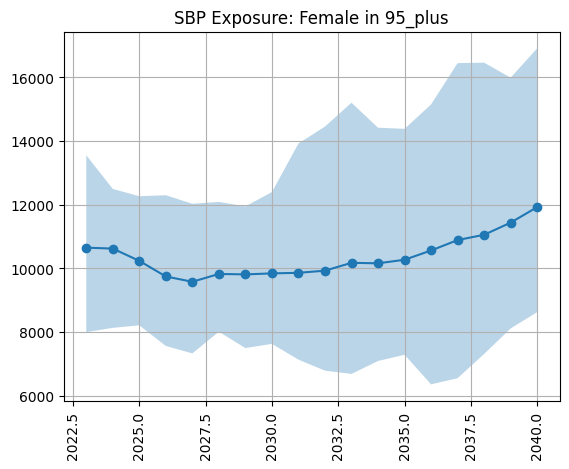

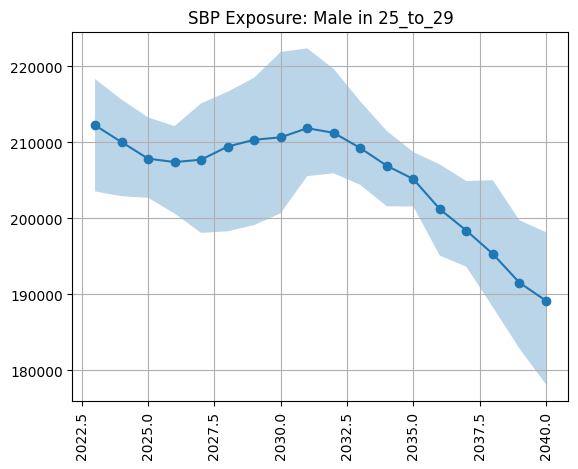

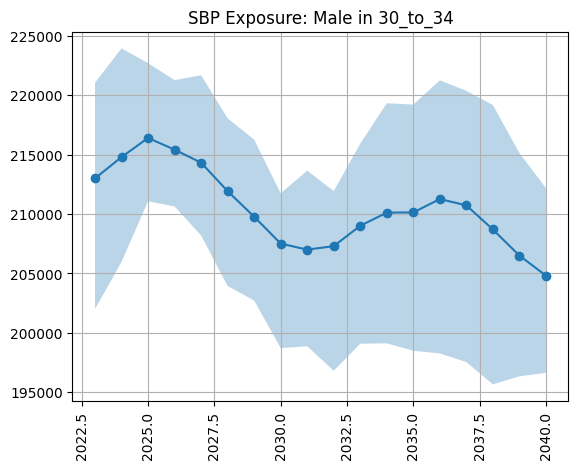

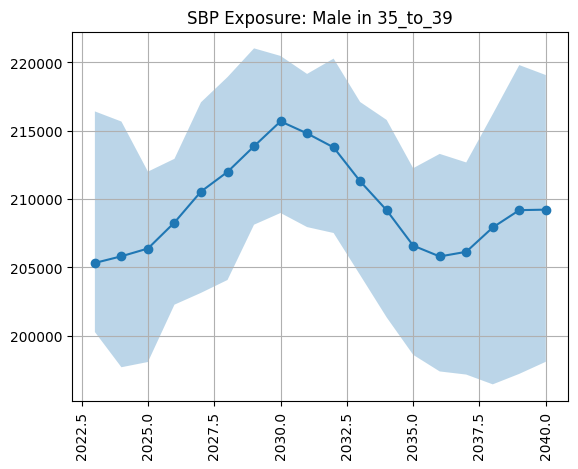

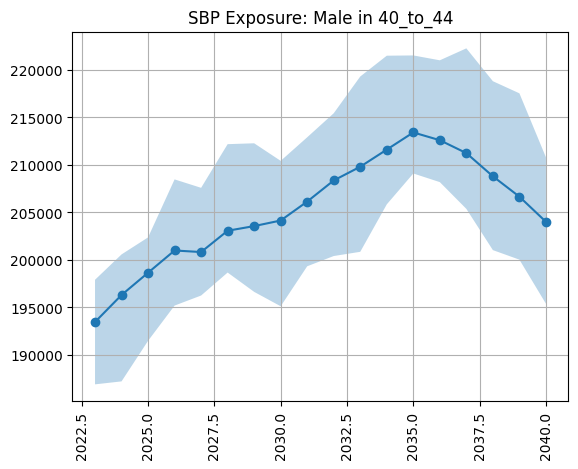

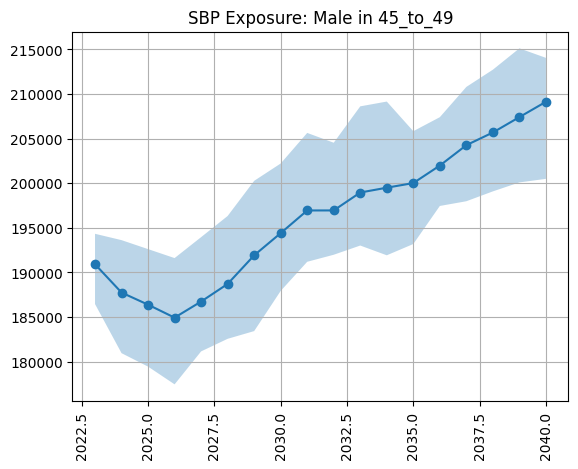

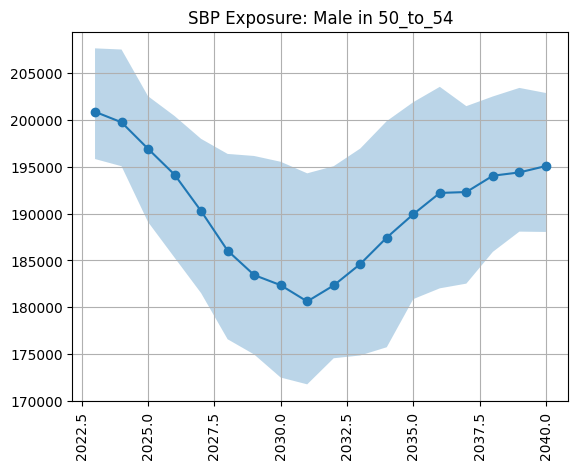

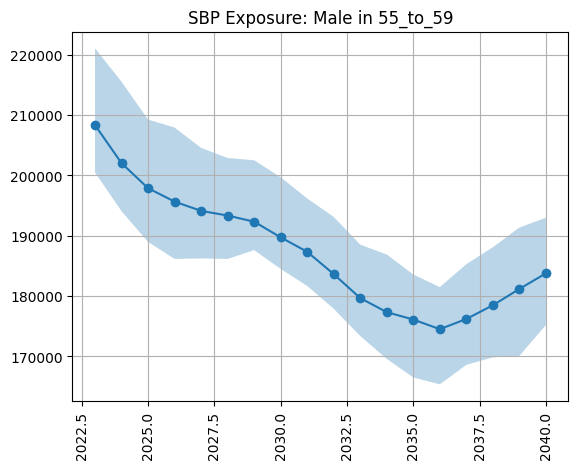

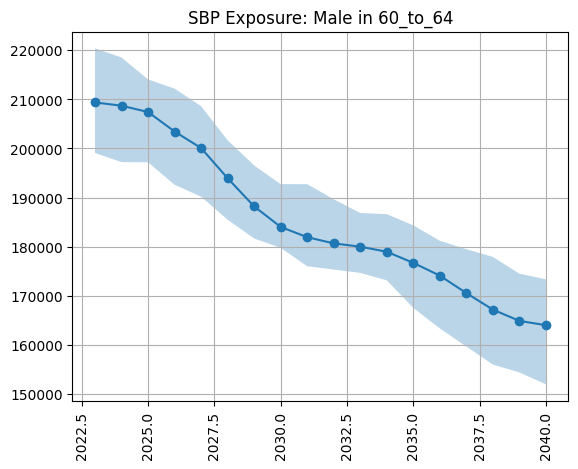

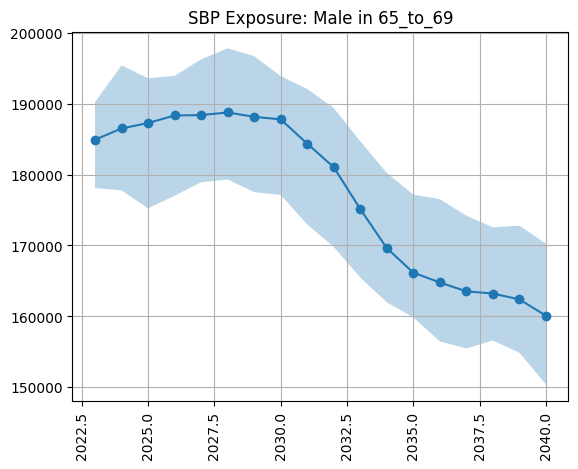

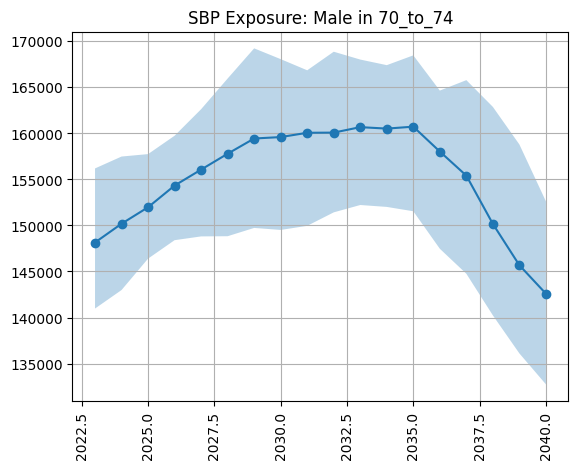

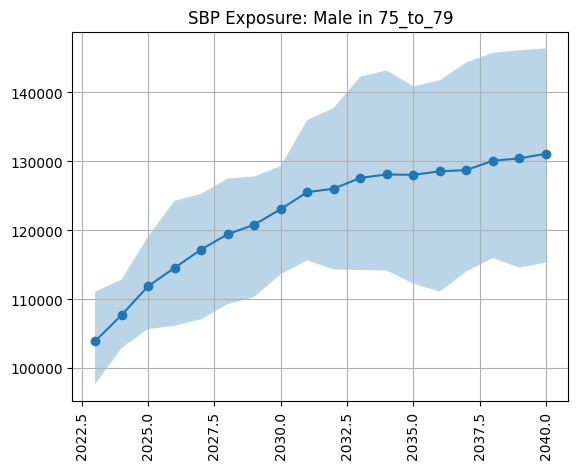

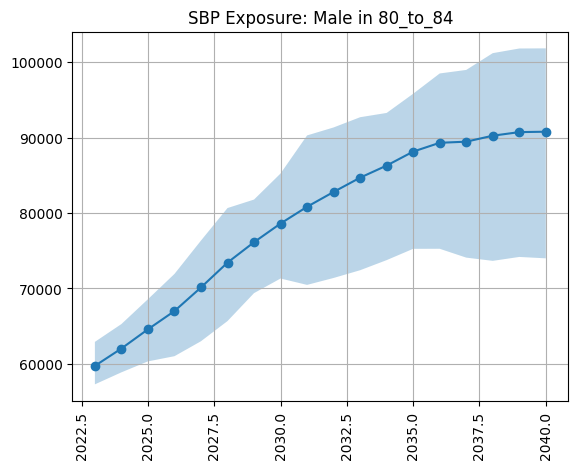

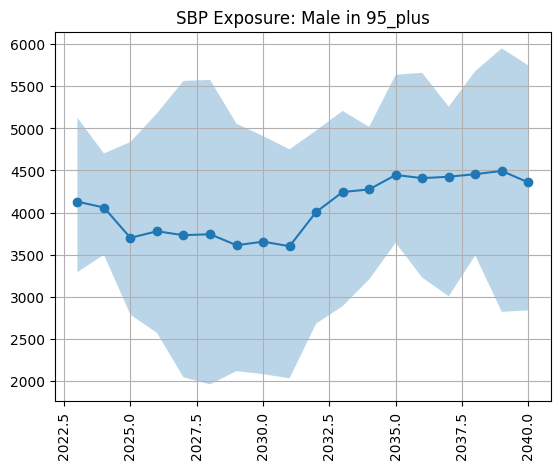

In [9]:
for sex in ldl_exp_rate_summ_sbp.sex.unique():
    for age in ldl_exp_rate_summ_sbp.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ_sbp.loc[(ldl_exp_rate_summ_sbp.sex==sex) & (ldl_exp_rate_summ_sbp.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

In [ ]:
for sex in ldl_exp_rate_summ_ptvalue.sex.unique():
    for age in ldl_exp_rate_summ_ptvalue.age.unique():
        plt.figure() 
        subdata = ldl_exp_rate_summ_ptvalue.loc[(ldl_exp_rate_summ_ptvalue.sex==sex) & (ldl_exp_rate_summ_ptvalue.age==age)]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'SBP Exposure: {sex} in {age}') 
        plt.xticks(rotation=90) 
        #plt.ylim(0,100000)
        plt.grid()

## Comparison to Artifacts

In [8]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/

51-locations/                       north_dakota.hdf  washington.hdf
alabama.hdf                         raw_data/         west_virginia.hdf
alabama_before_calculated_pafs.hdf  rhode_island.hdf


In [9]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [10]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

location     sex  age_start  age_end  year_start  year_end          value
0  Alabama  Female       25.0     30.0        2019      2020  171101.787730
1  Alabama  Female       30.0     35.0        2019      2020  162707.127245
2  Alabama  Female       35.0     40.0        2019      2020  160738.561697
3  Alabama  Female       40.0     45.0        2019      2020  151811.937430
4  Alabama  Female       45.0     50.0        2019      2020  160780.871213

In [22]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.myocardial_infarction.incidence_rate',
 'cause.acute_myocardial_infarction.disability_weight',
 'cause.post_myocardial_infarction.disability_weight',
 'cause.acute_myocardial_infarctio

In [12]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_946']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### SBP

In [13]:
ldl_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
#ldl_art.reset_index(inplace=True)
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

sex  age_start  age_end  year_start  year_end   parameter        mean  \
0  Female       25.0     30.0        2019      2020  continuous  110.635893   
1  Female       30.0     35.0        2019      2020  continuous  112.876275   
2  Female       35.0     40.0        2019      2020  continuous  116.139886   
3  Female       40.0     45.0        2019      2020  continuous  118.491616   
4  Female       45.0     50.0        2019      2020  continuous  121.645391   

          50%        2.5%       97.5% location   measure age_group  
0  110.623634  107.945700  113.550750  Alabama  exposure  25_to_29  
1  112.881309  110.098198  115.523727  Alabama  exposure  30_to_34  
2  116.134678  113.594023  118.770064  Alabama  exposure  35_to_39  
3  118.514616  115.903577  121.039457  Alabama  exposure  40_to_44  
4  121.618436  118.875235  124.529834  Alabama  exposure  45_to_49

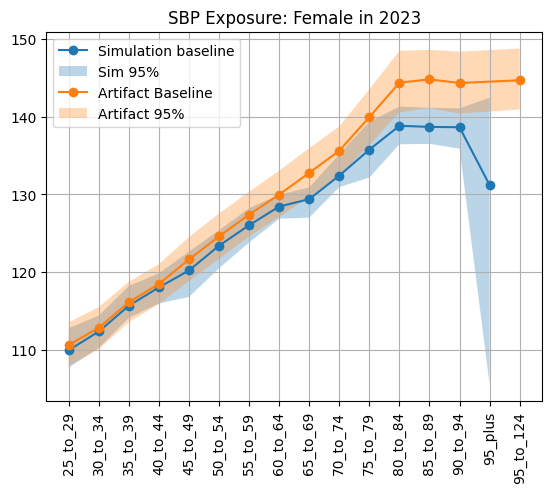

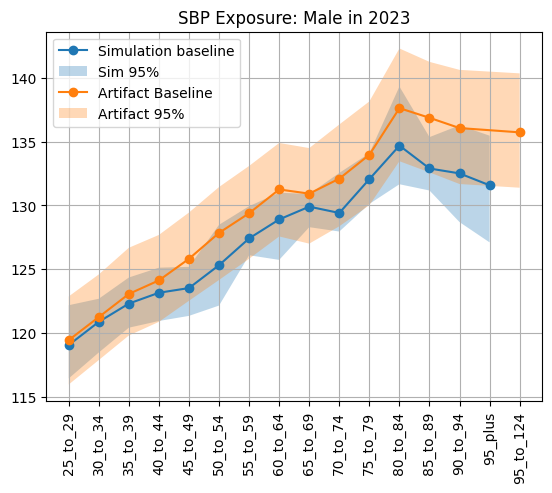

In [14]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

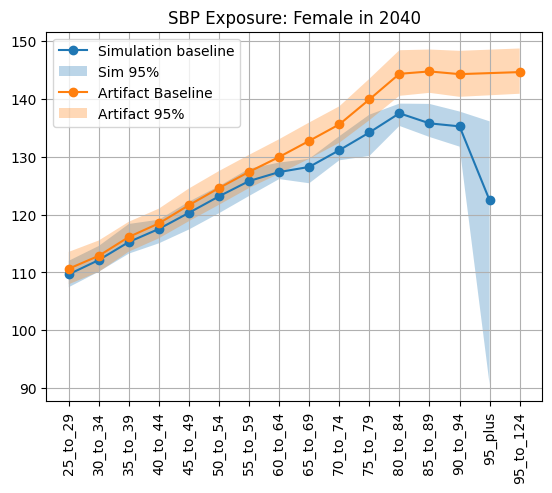

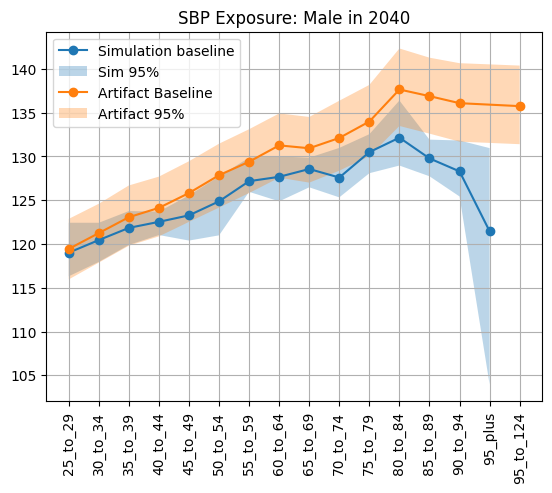

In [15]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2040') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### LDL-C

In [23]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
#ldl_art.reset_index(inplace=True)
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

sex  age_start  age_end  year_start  year_end   parameter      mean  \
0  Female       25.0     30.0        2019      2020  continuous  2.639862   
1  Female       30.0     35.0        2019      2020  continuous  2.724353   
2  Female       35.0     40.0        2019      2020  continuous  2.802925   
3  Female       40.0     45.0        2019      2020  continuous  2.880791   
4  Female       45.0     50.0        2019      2020  continuous  2.998297   

        50%      2.5%     97.5% location   measure age_group  
0  2.638003  2.472574  2.821188  Alabama  exposure  25_to_29  
1  2.723671  2.553736  2.905134  Alabama  exposure  30_to_34  
2  2.801341  2.639513  2.972487  Alabama  exposure  35_to_39  
3  2.878250  2.721814  3.039119  Alabama  exposure  40_to_44  
4  2.995129  2.837974  3.175367  Alabama  exposure  45_to_49

In [ ]:
for sex in ldl_exp_rate_summ.sex.unique():
    plt.figure() 
    subdata = ldl_exp_rate_summ.loc[(ldl_exp_rate_summ.sex==sex) & (ldl_exp_rate_summ.year==2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'SBP Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Medication

In [16]:
meds = pd.read_csv(sim_results_dir + '/sbp_medication_person_time.csv')
meds.head()

Unnamed: 0     sex  year                     measure  input_draw  scenario  \
0           0  Female  2023  sbp_medication_person_time          29  baseline   
1           1  Female  2023  sbp_medication_person_time          29  baseline   
2           2  Female  2023  sbp_medication_person_time          29  baseline   
3           3  Female  2023  sbp_medication_person_time          29  baseline   
4           4  Female  2023  sbp_medication_person_time          29  baseline   

        age    medication_adherence sbp_medication        value  
0  25_to_29    primary_non_adherent   no_treatment   265.549624  
1  25_to_29  secondary_non_adherent   no_treatment   176.317591  
2  25_to_29                adherent   no_treatment  1240.432580  
3  30_to_34    primary_non_adherent   no_treatment   218.787132  
4  30_to_34  secondary_non_adherent   no_treatment   144.120465

In [17]:
meds_adherent = meds.loc[meds['medication_adherence']=='adherent'].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['sex', 'age', 'year', 'sbp_medication','scenario'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ

sex       age  year                 sbp_medication  scenario  \
0     Female  25_to_29  2023                   no_treatment  baseline   
1     Female  25_to_29  2023    one_drug_half_dose_efficacy  baseline   
2     Female  25_to_29  2023     one_drug_std_dose_efficacy  baseline   
3     Female  25_to_29  2023  three_drug_half_dose_efficacy  baseline   
...      ...       ...   ...                            ...       ...   
3776    Male   95_plus  2040  three_drug_half_dose_efficacy  baseline   
3777    Male   95_plus  2040   three_drug_std_dose_efficacy  baseline   
3778    Male   95_plus  2040    two_drug_half_dose_efficacy  baseline   
3779    Male   95_plus  2040     two_drug_std_dose_efficacy  baseline   

          mean      2.5%     97.5%  
0     0.665038  0.650587  0.684523  
1     0.046445  0.036149  0.056252  
2     0.001049  0.000000  0.002532  
3     0.000712  0.000000  0.001841  
...        ...       ...       ...  
3776  0.045415  0.004532  0.070231  
3777  0.154320  0.085638  0.268697  
3778  0.110610  0.054524  0.189188  
3779  0.044441  0.000000  0.093246  

[3780 rows x 8 columns]

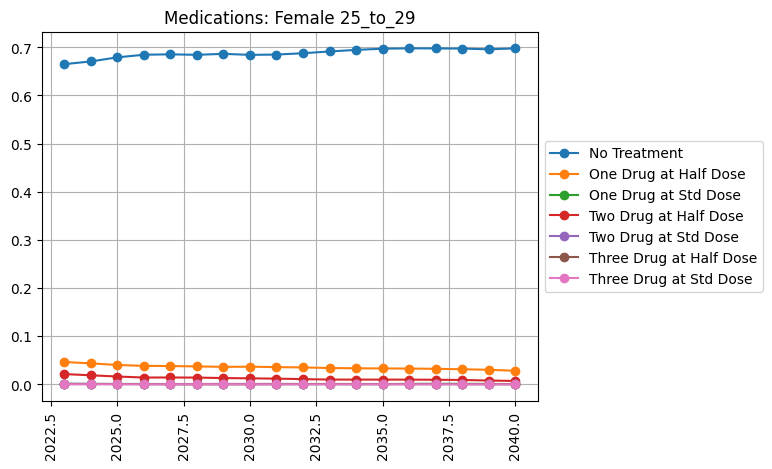

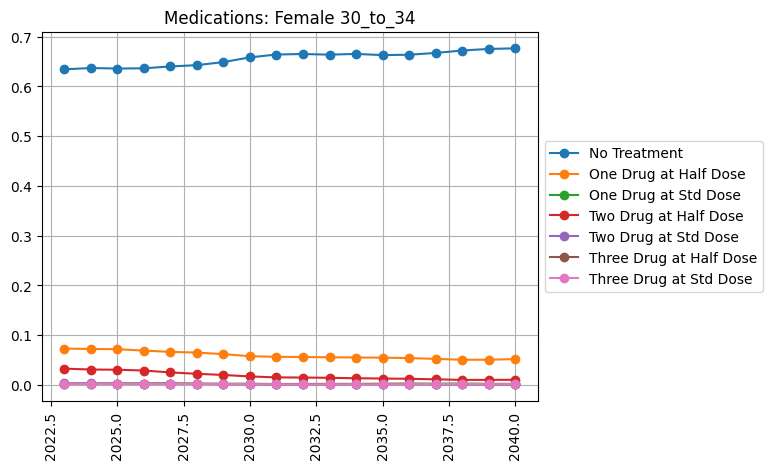

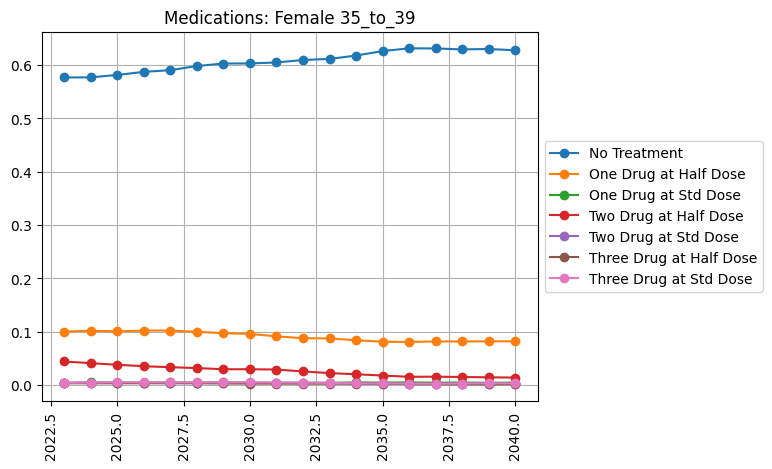

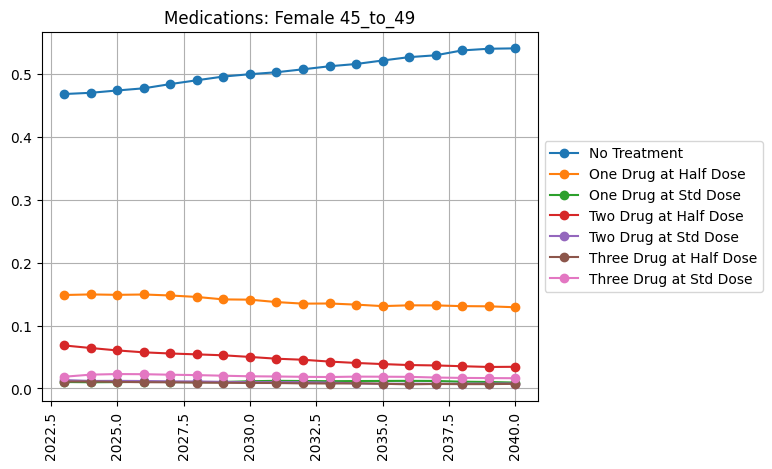

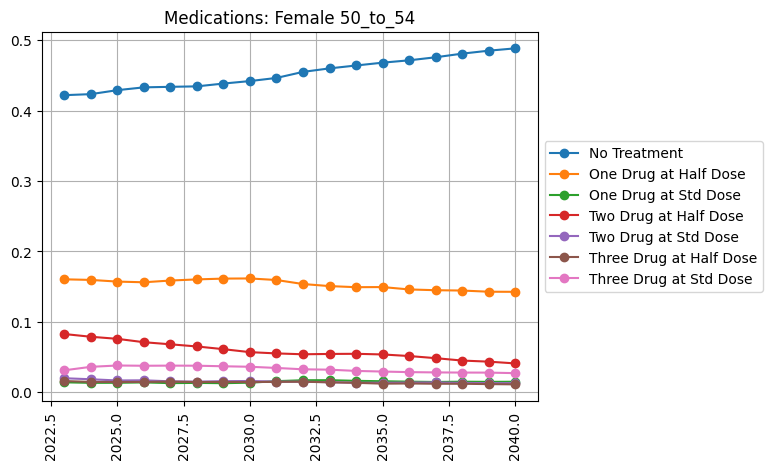

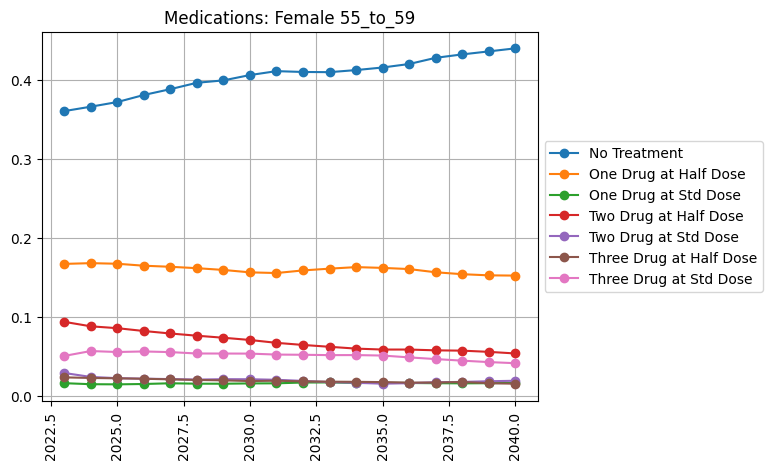

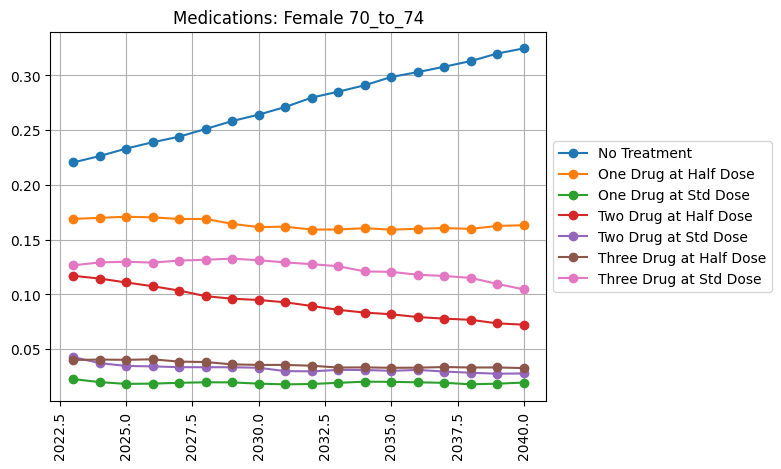

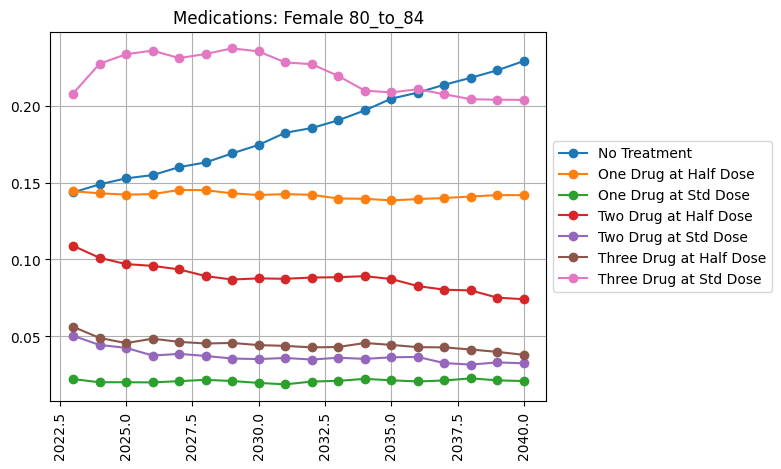

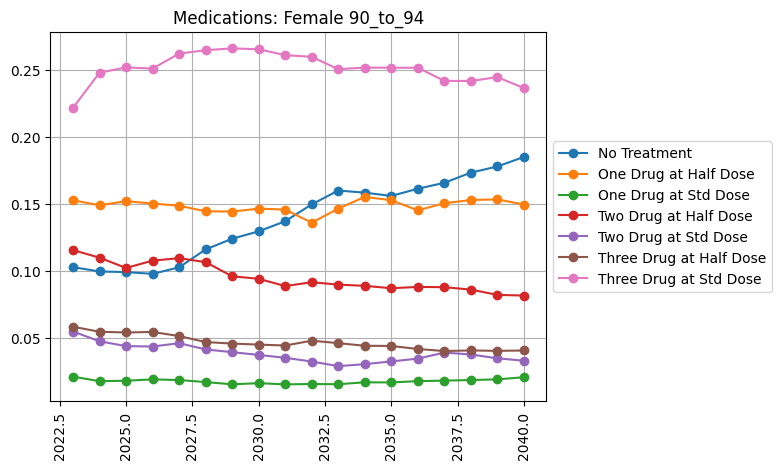

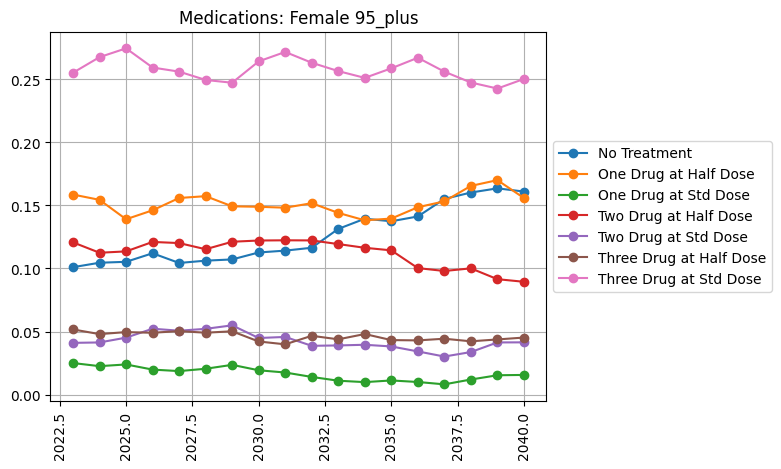

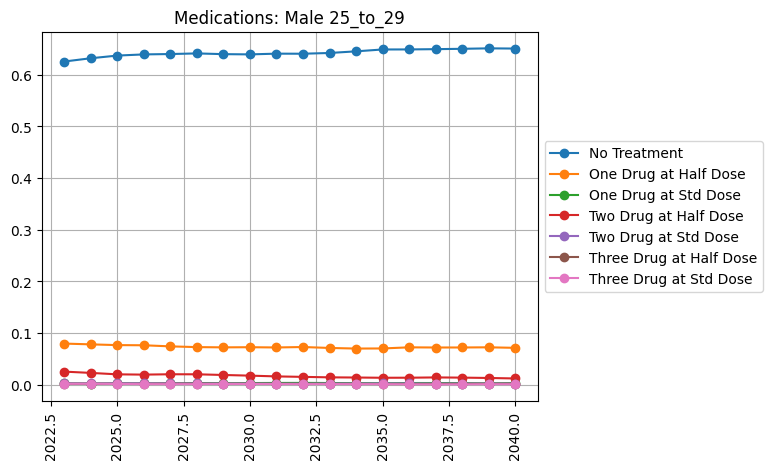

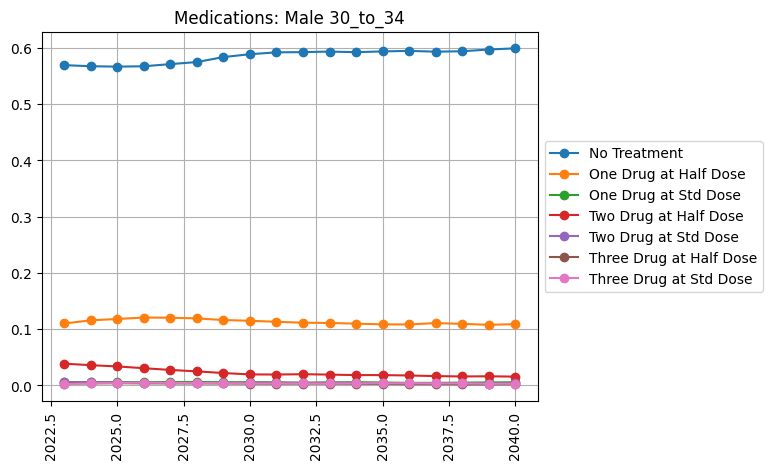

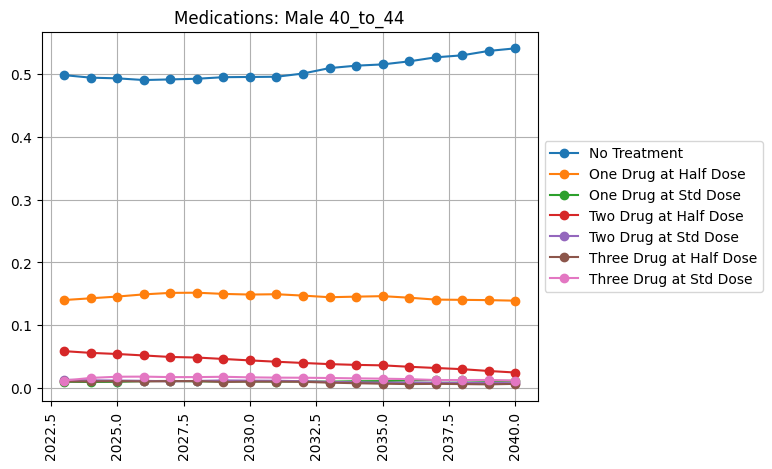

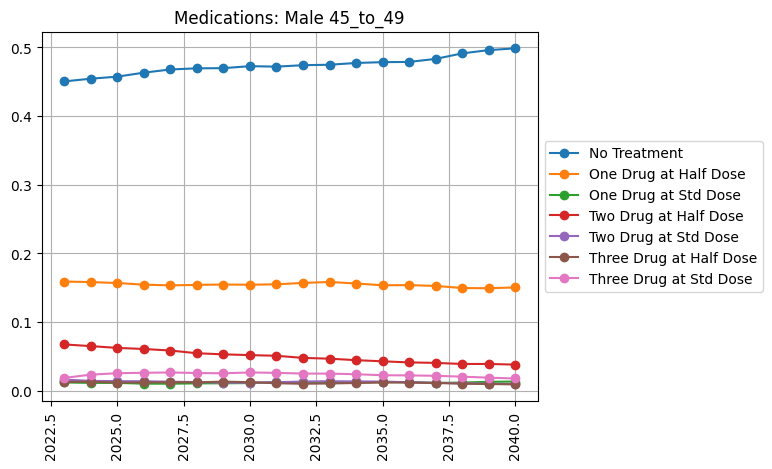

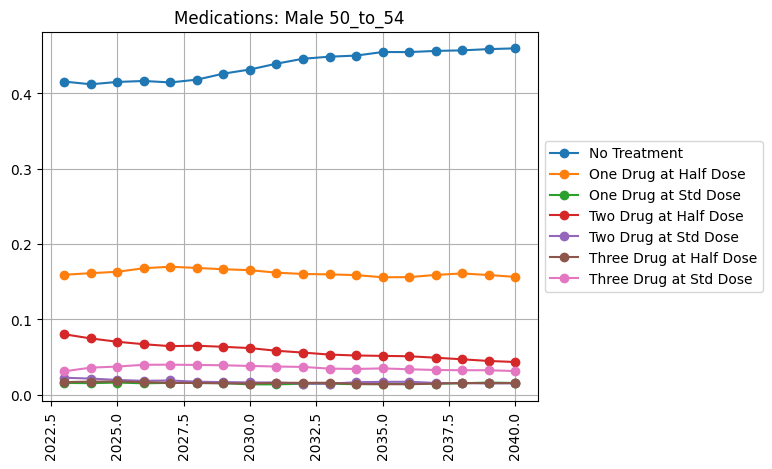

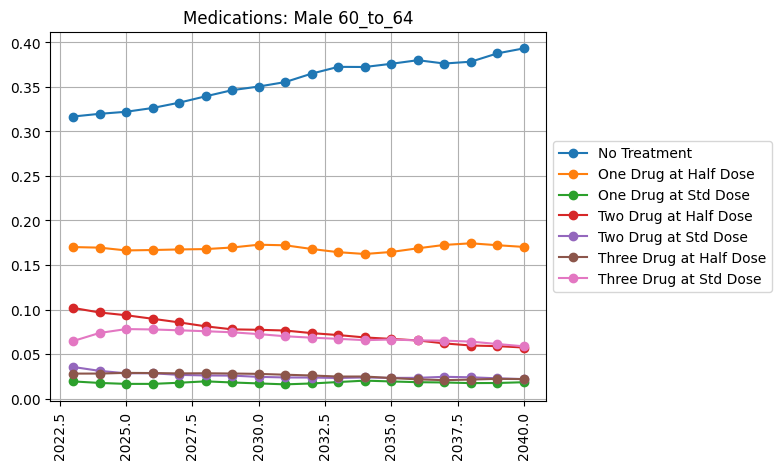

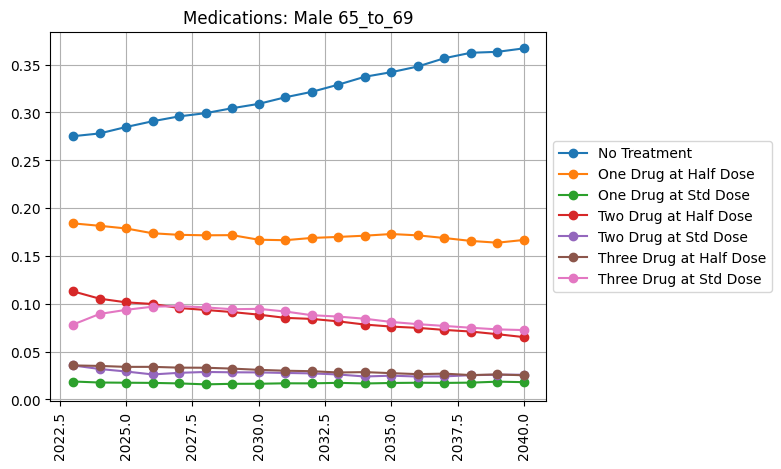

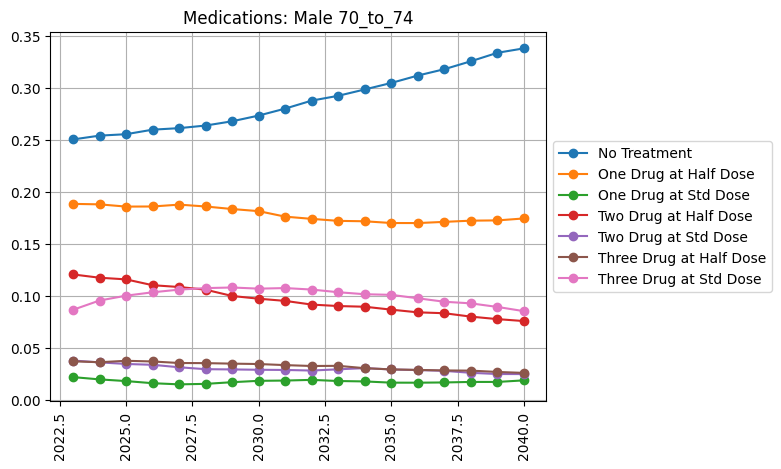

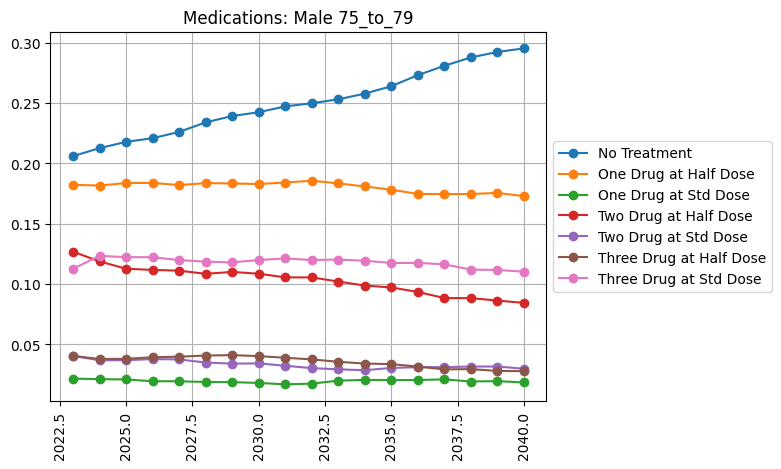

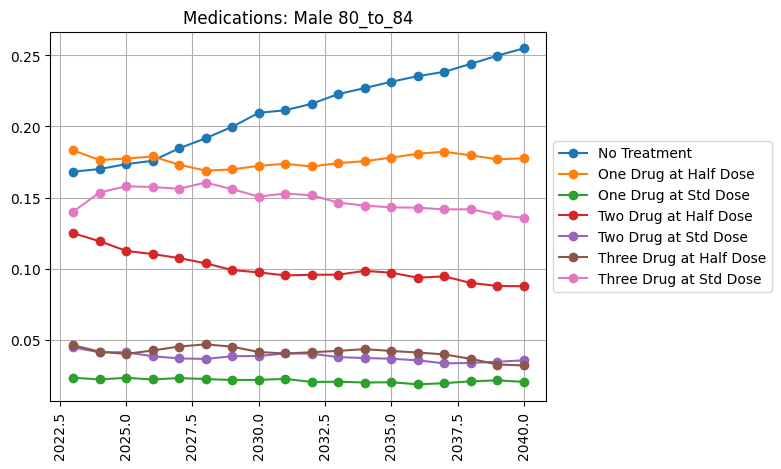

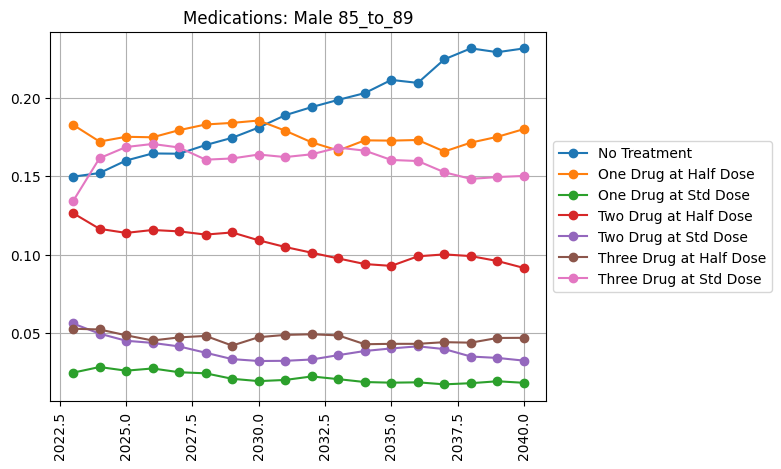

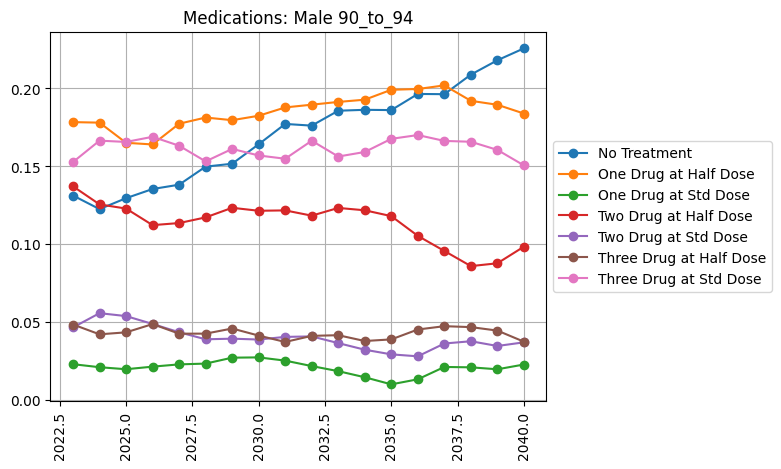

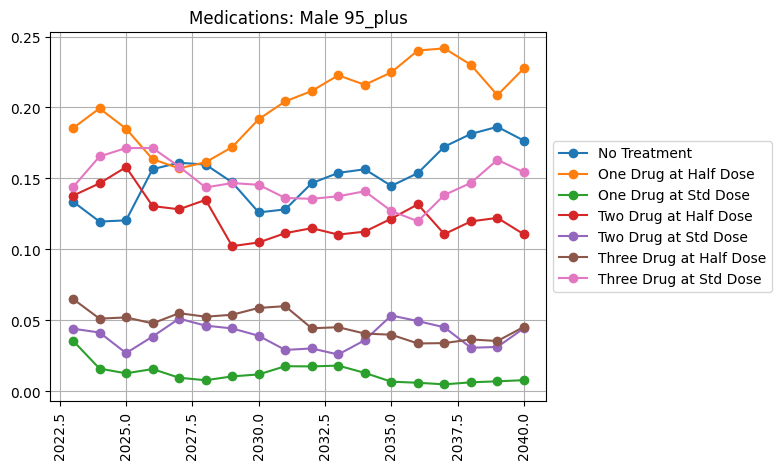

In [18]:
#%%capture
with PdfPages('sbp_treatment_age_sex_07212023.pdf') as pdf:
    for sex in meds_adherent_rate_summ.sex.unique():
        for age in meds_adherent_rate_summ.age.unique():
            plt.figure() 
            no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='no_treatment')]
            plt.plot(no_trt['year'], no_trt['mean'], marker='o')
            one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='one_drug_half_dose_efficacy')]
            plt.plot(one_half['year'], one_half['mean'], marker='o')
            one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='one_drug_std_dose_efficacy')]
            plt.plot(one_std['year'], one_std['mean'], marker='o')
            two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='two_drug_half_dose_efficacy')]
            plt.plot(two_half['year'], two_half['mean'], marker='o')
            two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='two_drug_std_dose_efficacy')]
            plt.plot(two_std['year'], two_std['mean'], marker='o')
            three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='three_drug_half_dose_efficacy')]
            plt.plot(three_half['year'], three_half['mean'], marker='o')
            three_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.sbp_medication=='three_drug_std_dose_efficacy')]
            plt.plot(three_std['year'], three_std['mean'], marker='o')
            plt.title(f'Medications: {sex} {age}') 
            plt.xticks(rotation=90)
            plt.legend(['No Treatment', 'One Drug at Half Dose','One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose','Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### LDL-C Meds

In [19]:
ldl_meds = pd.read_csv(sim_results_dir + '/ldlc_medication_person_time.csv')
ldl_meds.head()

Unnamed: 0     sex  year                      measure  input_draw  \
0           0  Female  2023  ldlc_medication_person_time          29   
1           1  Female  2023  ldlc_medication_person_time          29   
2           2  Female  2023  ldlc_medication_person_time          29   
3           3  Female  2023  ldlc_medication_person_time          29   
4           4  Female  2023  ldlc_medication_person_time          29   

   scenario       age    medication_adherence ldlc_medication      value  
0  baseline  25_to_29    primary_non_adherent  high_intensity   0.000000  
1  baseline  25_to_29  secondary_non_adherent  high_intensity   0.000000  
2  baseline  25_to_29                adherent  high_intensity  13.568789  
3  baseline  30_to_34    primary_non_adherent  high_intensity   0.000000  
4  baseline  30_to_34  secondary_non_adherent  high_intensity   0.000000

In [20]:
meds_adherent = ldl_meds.loc[(ldl_meds['medication_adherence']=='adherent') & (ldl_meds['scenario']=='baseline')].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw']], on=['sex','age','year','input_draw'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['sex', 'age','year', 'ldlc_medication'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ.head()

sex       age  year   ldlc_medication      mean      2.5%     97.5%
0  Female  25_to_29  2023    high_intensity  0.008064  0.005966  0.010435
1  Female  25_to_29  2023     high_with_eze  0.000000  0.000000  0.000000
2  Female  25_to_29  2023     low_intensity  0.001219  0.000347  0.002056
3  Female  25_to_29  2023  low_med_with_eze  0.000000  0.000000  0.000000
4  Female  25_to_29  2023  medium_intensity  0.025056  0.021597  0.032880

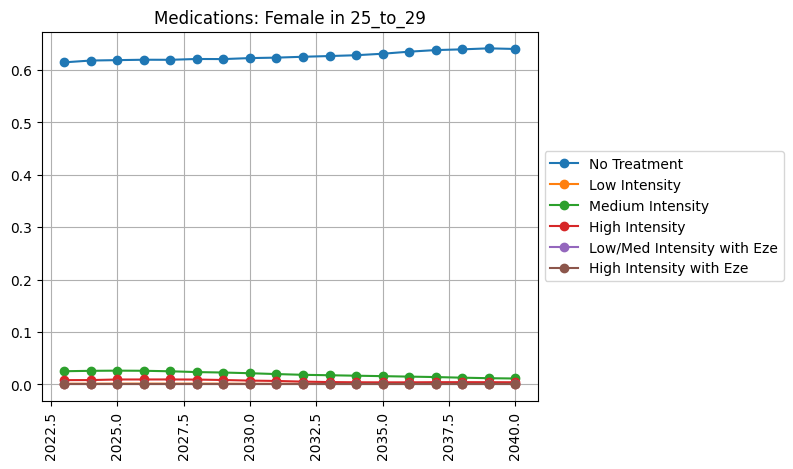

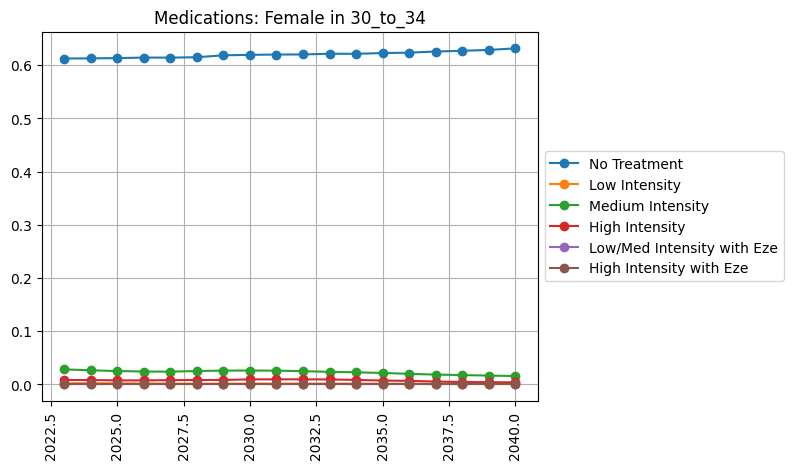

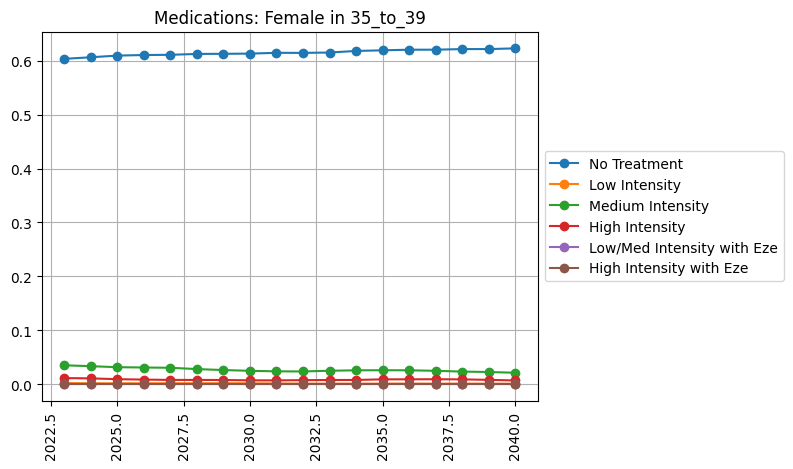

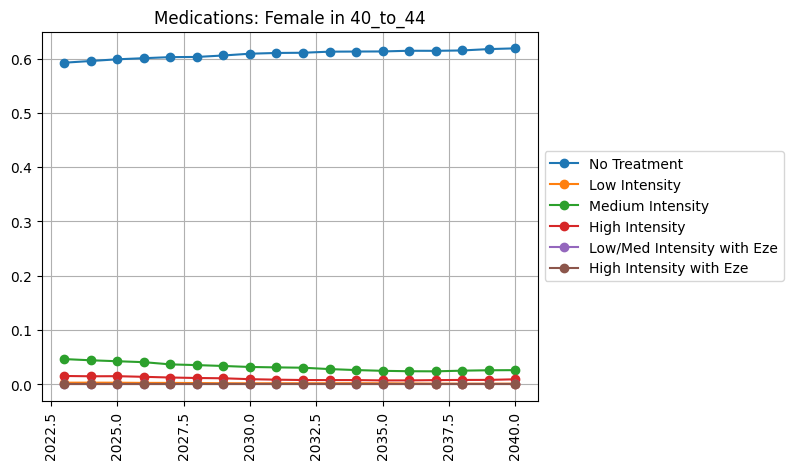

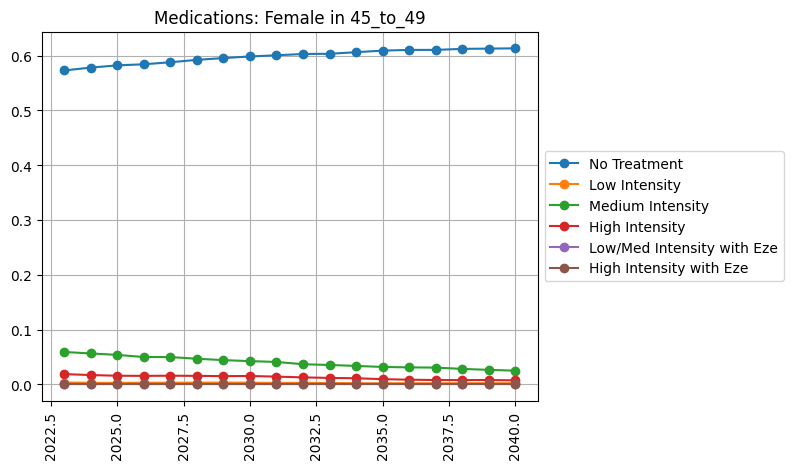

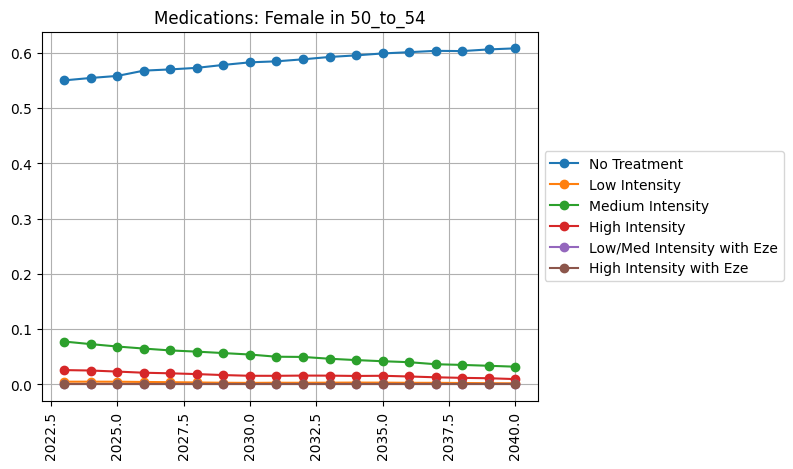

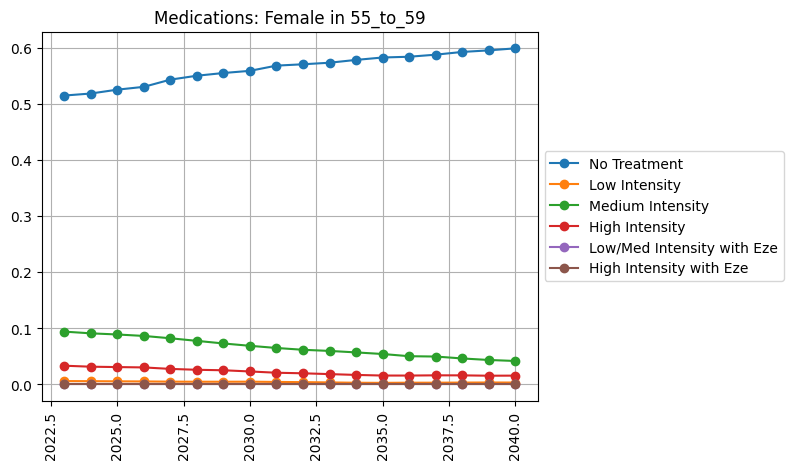

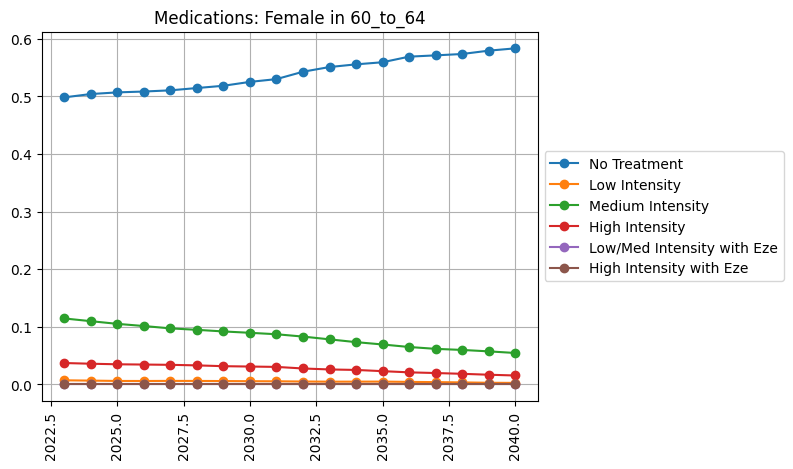

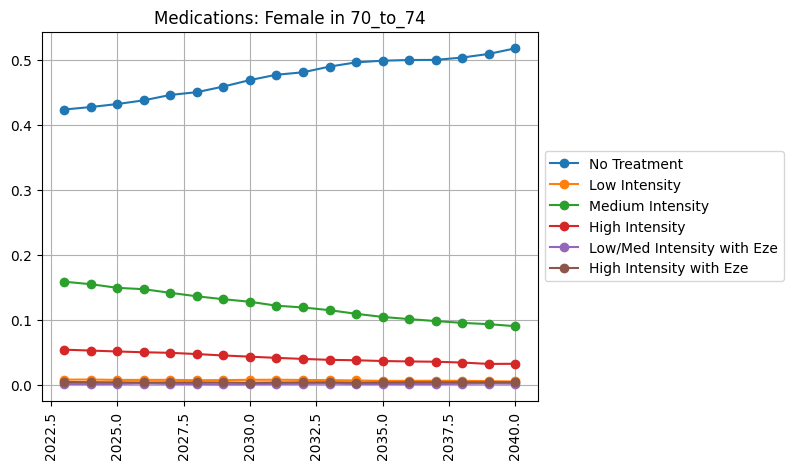

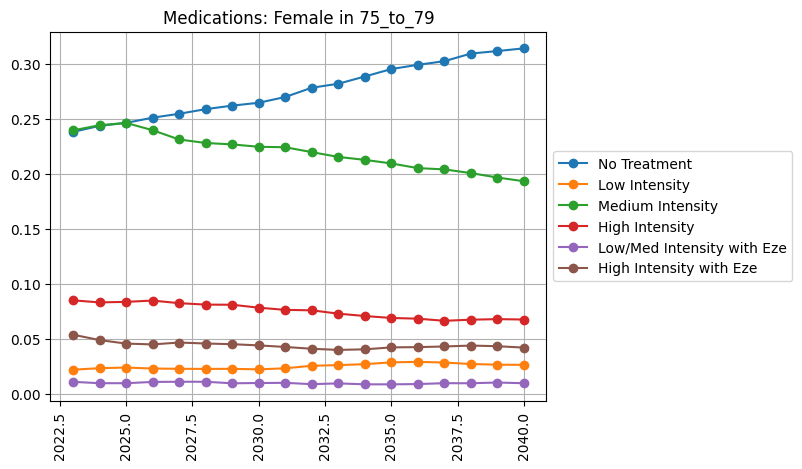

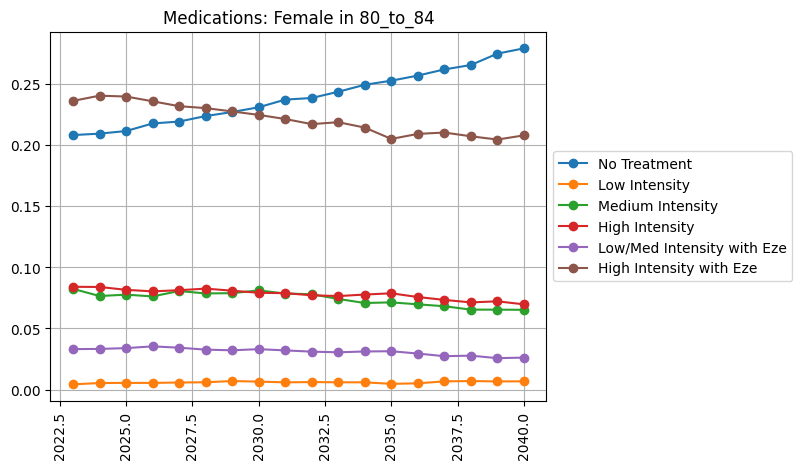

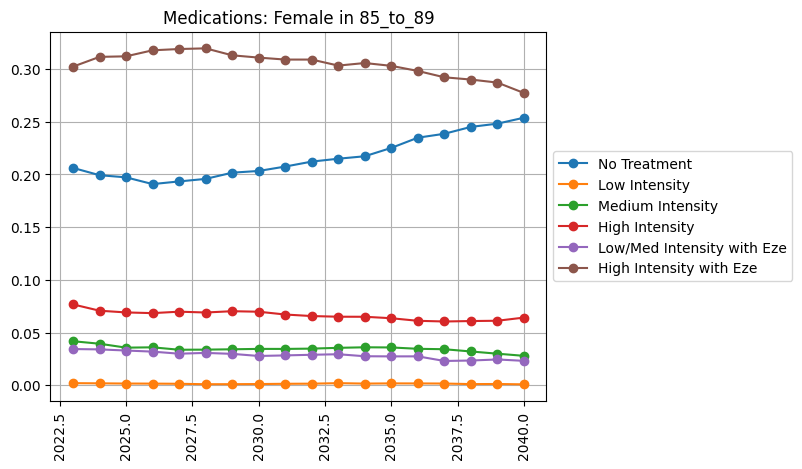

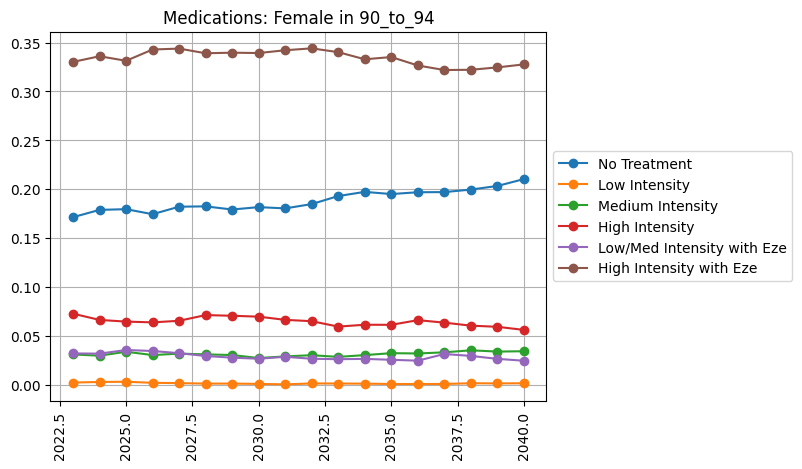

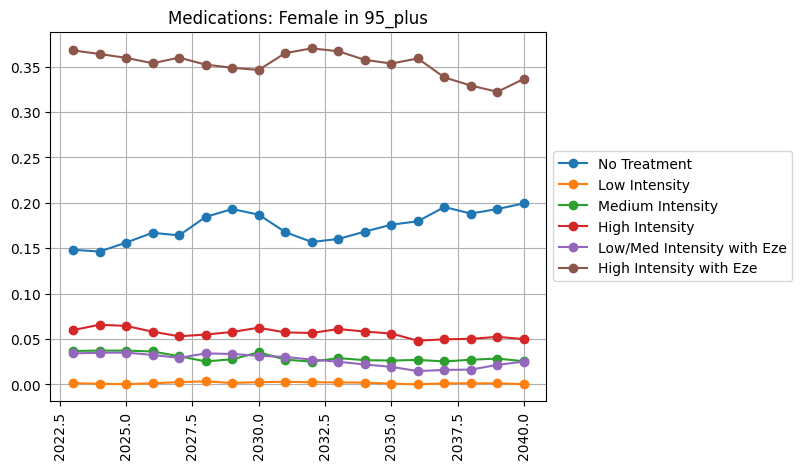

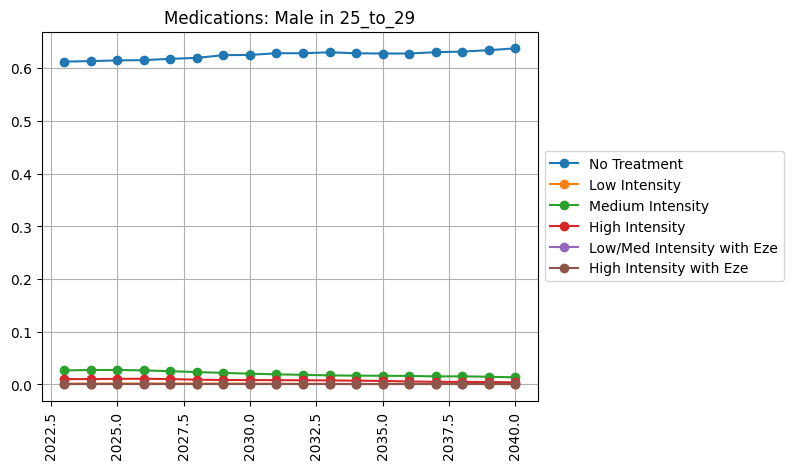

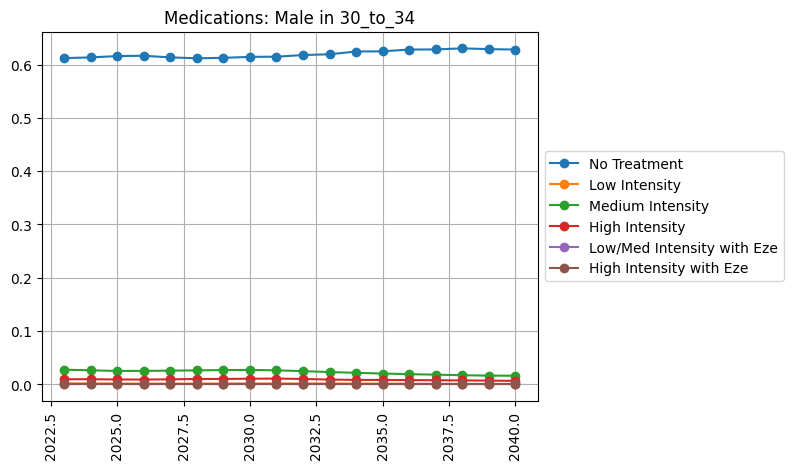

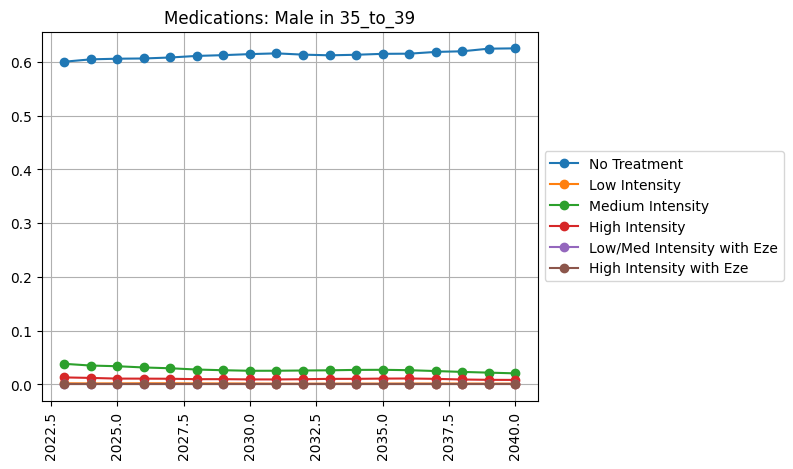

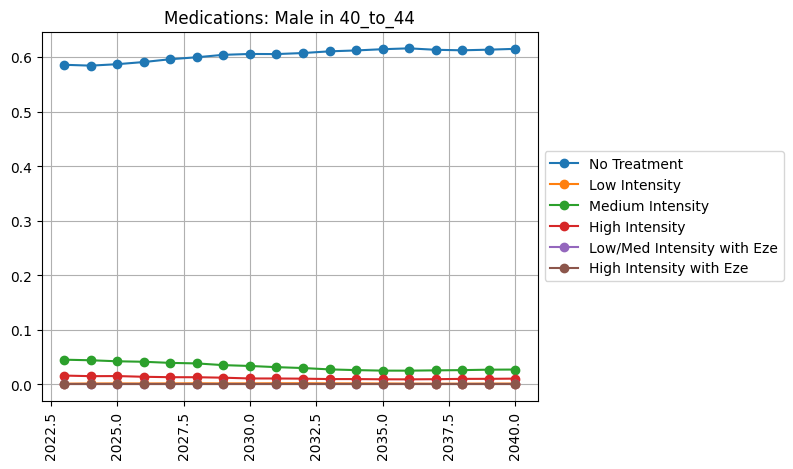

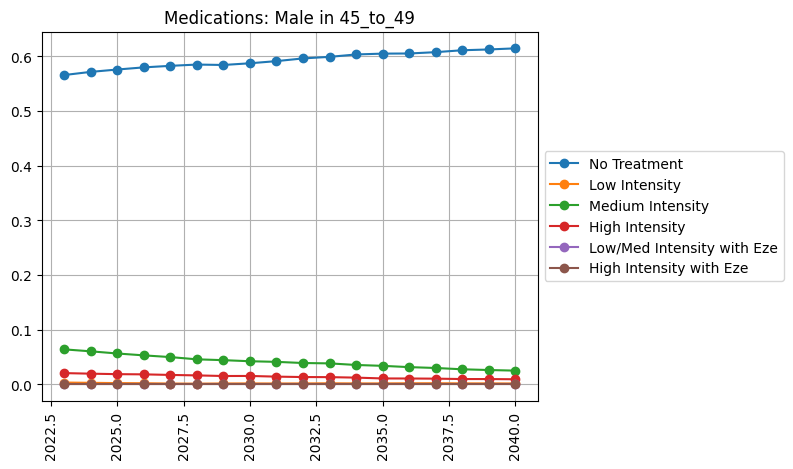

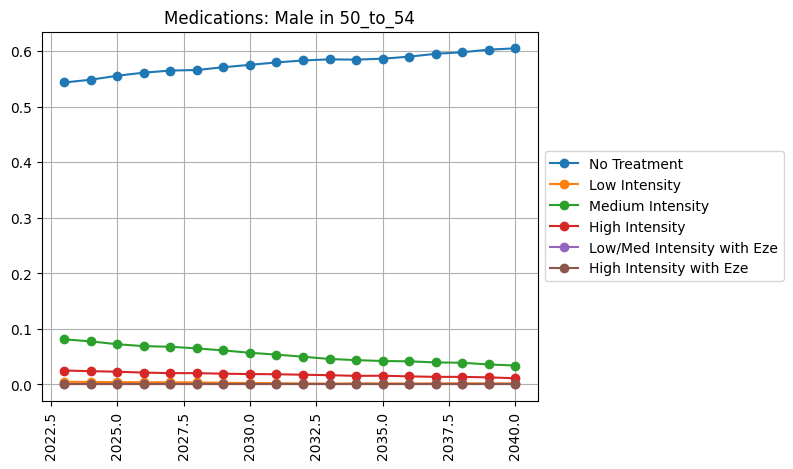

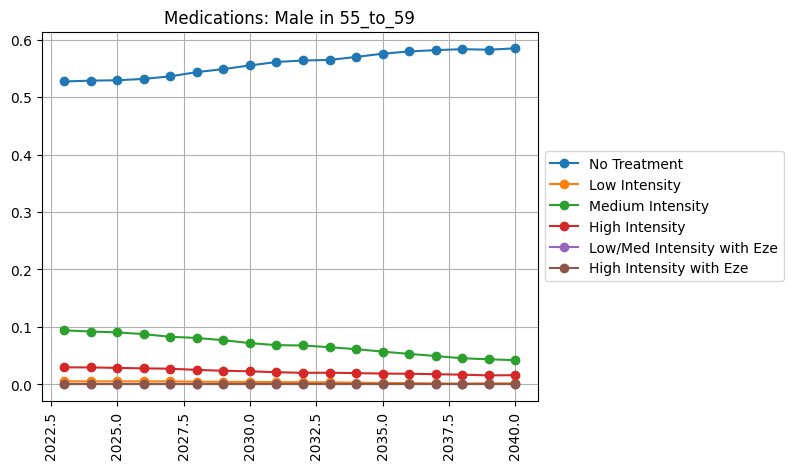

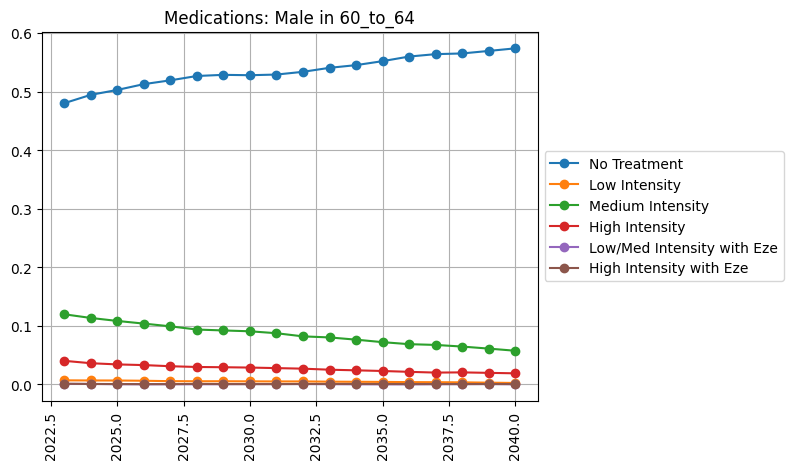

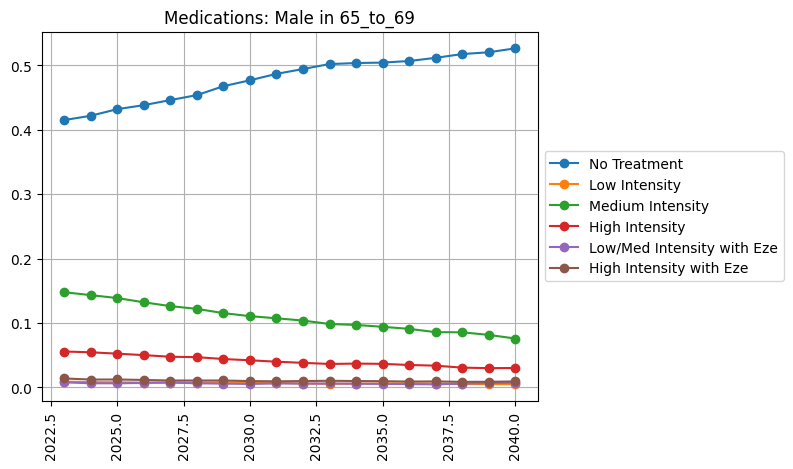

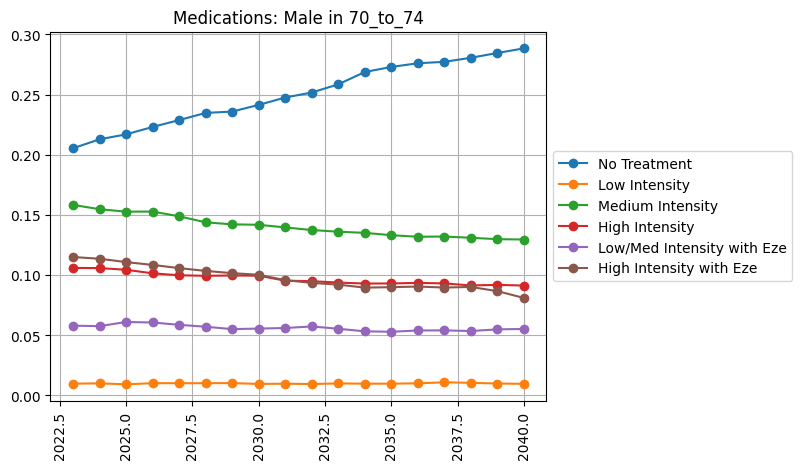

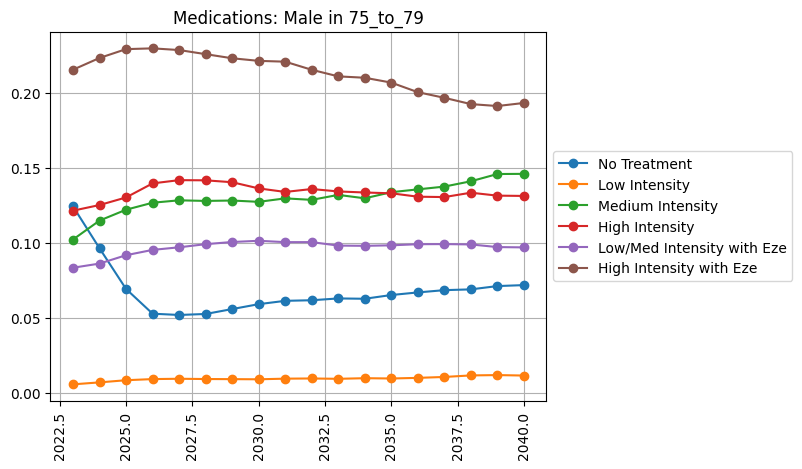

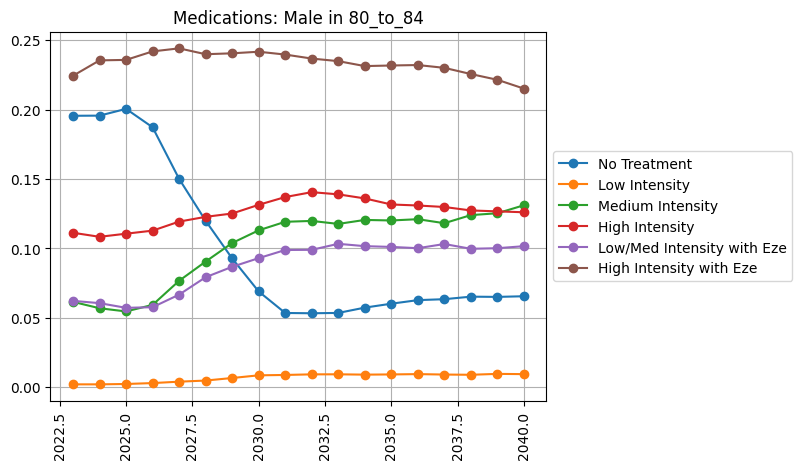

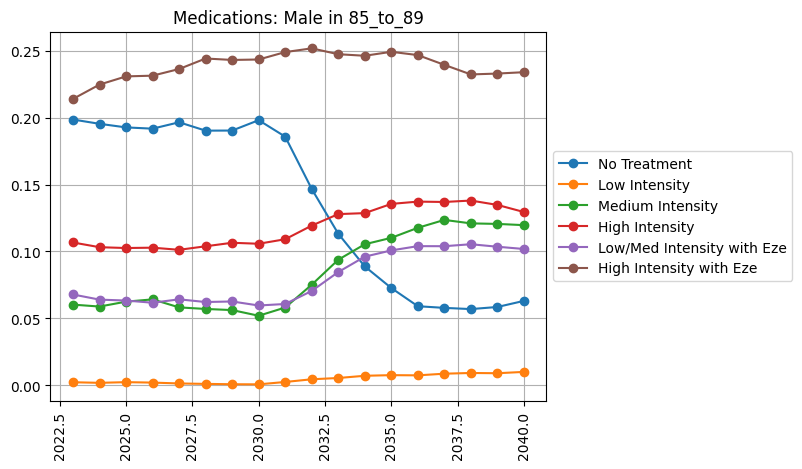

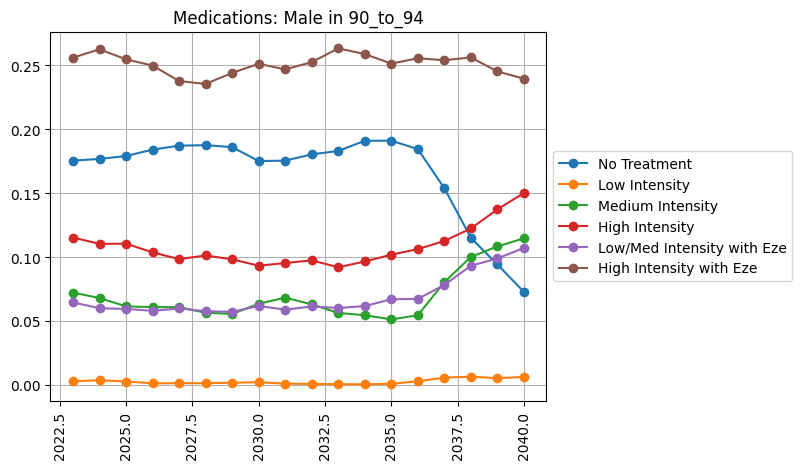

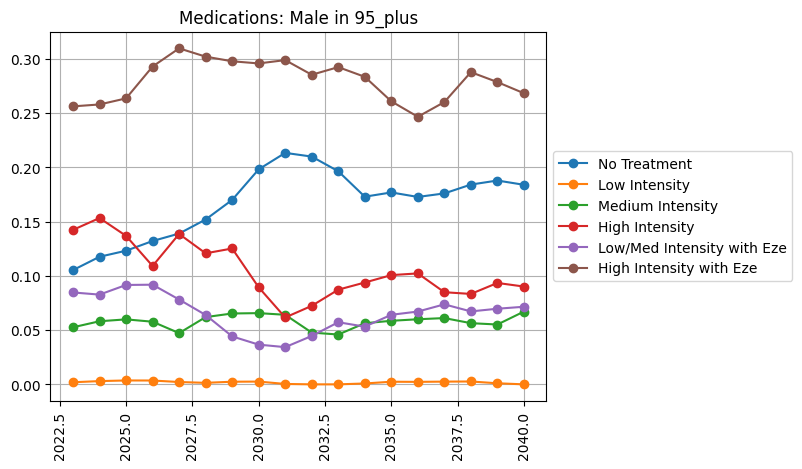

In [21]:
#%%capture
with PdfPages('ldlc_treatment_age_sex_07212023.pdf') as pdf:
    for sex in meds_adherent_rate_summ.sex.unique():
        for age in meds_adherent_rate_summ.age.unique():
            plt.figure() 
            no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='no_treatment')]
            plt.plot(no_trt['year'], no_trt['mean'], marker='o')
            one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_intensity')]
            plt.plot(one_half['year'], one_half['mean'], marker='o')
            one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='medium_intensity')]
            plt.plot(one_std['year'], one_std['mean'], marker='o')
            two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_intensity')]
            plt.plot(two_half['year'], two_half['mean'], marker='o')
            two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='low_med_with_eze')]
            plt.plot(two_std['year'], two_std['mean'], marker='o')
            three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.age==age) & (meds_adherent_rate_summ.ldlc_medication=='high_with_eze')]
            plt.plot(three_half['year'], three_half['mean'], marker='o')
            plt.title(f'Medications: {sex} in {age}') 
            plt.xticks(rotation=90)
            plt.legend(['No Treatment','Low Intensity','Medium Intensity','High Intensity','Low/Med Intensity with Eze','High Intensity with Eze'],loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            pdf.savefig(bbox_inches='tight')